# 프로젝트 : Segmentation map으로 도로 이미지 만들기

## 평가 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	상세기준
1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.: 데이터 분석 과정 및 1가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.
2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.: U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.:
3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.: 10 epoch 이상의 학습을 진행한 후 최종 테스트결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.

- 이전 Pix2Pix 논문에서 제시한 결과 중에 아래와 같은 실험 결과가 있었습니다. 도로의 레이블 정보를 활용해 이미지를 생성해낸 결과입니다.

- 이번 프로젝트는 위와 같은 데이터셋을 이용해 Pix2Pix를 학습시켜보는 것입니다. 데이터셋은 아래에서 다운로드 할 수 있습니다.
- 1000개의 학습용 이미지 및 5개의 평가 이미지를 포함합니다.

![title](p2p_result_seg.max-800x600.png) 

- cityscapes.zip 
- 이전 포켓몬 데이터에서 사용했던 스케치와는 조금 다른 레이블 정보 이미지를 입력으로 사용하기 때문에, 전처리 과정에 대해 약간의 혼란이 있을 수 있지만 크게 다른 과정은 없습니다.
- 아래 Tensorflow에서 제공하는 Pix2Pix 튜토리얼은 위 이미지와 비슷한 레이블 정보 이미지를 사용하기 때문에 좋은 참고 자료가 될 수 있을 것 같습니다.

- 프로젝트 시작에 어려움이 있다면 아래 튜토리얼을 참고하시면서 이번 프로젝트를 수행해봅시다.
- (아래 튜토리얼은 Pix2Pix 구조를 Functional API를 이용해 구현하기 때문에 이번에 진행한 Subclassing 방법을 이용한 모델 구현과 비교하면서 구현 방법에 대해서도 공부해 보시길 추천드립니다)

- Tensorflow Pix2Pix Tutorial
- 프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

    1. 데이터에 1 가지 이상의 augmentation 방법을 적용하여 학습해주세요. (어떠한 방법을 사용했는지 적어주세요).
    2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.
    3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내에서 아무 이미지나 사용해주세요.
    4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 (스케치, 생성된 사진, 실제 사진) 순서로 나란히 시각화해 주세요.
    5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요.
- 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

# 내가 원하는 숫자 이미지 만들기 (1) Generator 구성하기
- 이제부터는 앞에서 계속 비교해온 GAN과 cGAN을 각각 간단하게 구현하고 실험해보겠습니다.
- 간단한 실험을 위해 MNIST 데이터셋을 이용합니다. 실습 코드는 아래를 참고하여 작성했습니다.

## 데이터 준비하기
- tensorflow-datasets 라이브러리가 설치되어 있지 않다면, 터미널을 열어 아래와 같이 라이브러리를 설치해 주세요.

- \$ pip install tensorflow-datasets

- tensorflow-datasets 라이브러리에서 간단하게 MNIST 데이터셋을 불러와 확인해봅시다.



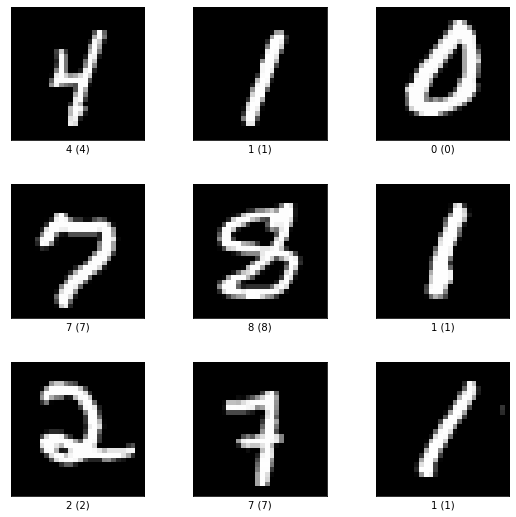

In [43]:
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings("ignore")

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

- 여러 개의 숫자 이미지와 그에 알맞은 레이블이 출력되었을 것입니다. 이어서 아래 코드를 실행해 학습 전에 필요한 몇 가지 처리를 수행하는 함수를 정의합니다.
- 이미지 픽셀 값을 -1~1 사이의 범위로 변경했고, 레이블 정보를 one-hot encoding 했습니다.
- GAN과 cGAN 각각을 실험해 보기 위해 label 정보 사용 유무에 따라 두 가지 함수를 구성해 놓았습니다.

In [44]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")

✅


- 원하는 대로 정확히 처리되었는지 한 개 데이터셋만 선택해 확인해봅시다. 이미지에 쓰인 숫자와 레이블이 일치해야 하고, 이미지 값의 범위가 -1~1 사이에 있어야 합니다.



Label : tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


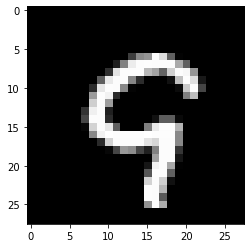

In [45]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

## GAN Generator 구성하기
- 이번 구현은 Tensorflow2의 Subclassing 방법을 이용하겠습니다.
- Subclassing 방법은 tensorflow.keras.Model 을 상속받아 클래스를 만들며, 일반적으로 __init__() 메서드 안에서 레이어 구성을 정의하고,
- 구성된 레이어를 call() 메서드에서 사용해 forward propagation을 진행합니다.
- 이러한 Subclassing 방법은 Pytorch의 모델 구성 방법과도 매우 유사하므로 이에 익숙해진다면 Pytorch의 모델 구성 방법도 빠르게 습득할 수 있습니다.
- 먼저 GAN의 Generator를 아래와 같이 구현합니다.

In [46]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅")

✅


- __init__() 메서드 안에서 사용할 모든 레이어를 정의했습니다. 4개의 fully-connected 레이어 중 한 개를 제외하고 모두 ReLU 활성화를 사용하는 것으로 확인됩니다.
- call() 메서드에서는 노이즈를 입력 받아 __init__()에서 정의된 레이어들을 순서대로 통과합니다.
- Generator는 숫자가 쓰인 이미지를 출력해야 하므로 마지막 출력은 layers.Reshape()을 이용해 (28,28,1) 크기로 변환됩니다.

## cGAN Generator 구성하기
- 이번에는 cGAN의 Generator를 살펴봅시다.


In [47]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


- GAN의 Generator보다 구현이 복잡한 듯 하지만 ,이전에 cGAN을 이해한대로 두 구조의 차이점은 레이블 정보가 추가된다는 것 뿐입니다.
- 이번에는 여러분이 위 코드를 자세히 보고, 어떠한 연산이 이루어지는지 생각해봅시다.
- cGAN의 ***입력은 2개(노이즈 및 레이블 정보)*** 라는 점을 기억해주세요. (이전 GAN코드와 비교하여 잘 생각해 봅시다)
- 위 코드로 생성한 모델에 대해 입력부터 출력까지 어떤 연산이 이루어지는지 설명해주세요.(init() 메서드에서는 노이즈 및 레이블 입력 각각에 적용할 레이어를 생성했습니다)
    - 노이즈 입력 및 레이블 입력은 각각 1개의 fully-connected 레이어와 ReLU 활성화를 통과합니다. (dense_z, dense_y)  
    - 1번 문항의 각 결과가 서로 연결되어 다시 한번 1개의 fully-connected 레이어와 ReLU 활성화를 통과합니다 (tf.concat, conbined_dense)  
    - 2번 문항의 결과가 1개의 fully-connected 레이어 및 Hyperbolic tangent 활성화를 거쳐 28x28 차원의 결과가 생성되고 (28,28,1) 크기의 이미지 형태로 변환되어 출력됩니다 (final_dense, reshape)


# 내가 원하는 숫자 이미지 만들기 (2) Discriminator 구성하기
## GAN Discriminator 구성하기
- 이전에 임의 노이즈 및 레이블 정보로부터 숫자 이미지를 생성하는 Generator를 구현했습니다.
- 이번에는 실제 이미지와 Generator가 생성한 이미지에 대해 진짜와 가짜를 식별하는 Discriminator를 구현해 보겠습니다.
- 먼저 GAN의 Discriminator를 아래와 같이 구현합니다.

In [48]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


- 여기에서는 __init__()에 blocks라는 리스트를 하나 만들어 놓고, for loop를 이용하여 필요한 레이어들을 차곡차곡 쌓아놓았습니다.
- 이러한 방식을 이용하면 각각의 fully-connected 레이어를 매번 정의하지 않아도 되므로 많은 레이어가 필요할 때 편리합니다.
- Discriminator의 입력은 Generator가 생성한 (28,28,1) 크기의 이미지이며, 이를 fully-connected 레이어로 학습하기 위해 call()에서는 가장 먼저 layers.Flatten()이 적용됩니다.
- 이어서 레이어들이 쌓여있는 blocks에 대해 for loop를 이용하여 레이어들을 순서대로 하나씩 꺼내 입력 데이터를 통과시킵니다.
- 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력됩니다.

## cGAN Discriminator 구성하기
- 다음으로 구현할 cGAN의 Discriminator는 Maxout이라는 특별한 레이어가 사용됩니다.
- Maxout은 간단히 설명하면 두 레이어 사이를 연결할 때, 여러 개의 fully-connected 레이어를 통과시켜 그 중 가장 큰 값을 가져오도록 합니다.
- 만약 2개의 fully-connected 레이어를 사용할 때 Maxout을 식으로 표현하면 아래와 같습니다.

- max(wT1x+b1, wT2x+b2)

- 아래 코드와 같이 Maxout을 구성할 수 있습니다.
- tensorflow.keras.layers.Layer 를 상속받아 레이어를 정의했습니다.
- 이전에 모델을 정의한 것과 비슷하게 __init__(), call() 메서드를 구성합니다.

In [49]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=1)

print("✅")

✅


- Maxout 레이어를 구성할 때 units과 pieces의 설정이 필요하며, units 차원 수를 가진 fully-connected 레이어를 pieces개 만큼 만들고 그 중 최대 값을 출력합니다.
- 예를 들어, 사용할 Maxout 레이어가 units=100, pieces=10으로 설정 된다면 입력으로 부터 100차원의 representation을 10개 만들고,
- 10개 중에서 최대값을 가져와 최종 1개의 100차원 representation이 출력됩니다. 식으로 나타낸다면 아래와 같습니다. (위 예시에서는 각각의 wx+b가 모두 100차원 입니다)
- 위에서 정의한 Maxout 레이어를 3번만 사용하면 아래와 같이 쉽게 cGAN의 Discriminator를 구성할 수 있습니다.
- 아래아 같은 cGAN의 Disciminator에 (28,28,1) 크기 이미지 및 (10,) 크기 레이블이 입력될 때, 연산의 순서를 다음과 같이 나타낼 수 있습니다.  
    - 이미지가 Maxout 레이어를 통과 : 240차원
    - 레이블이 Maxout 레이어를 통과 : 50차원
    - 1)과 2)결과로 나온 representation을 결합(concate) 후 Maxout 레이어를 통과 : 240차원 
- 위 3개 과정의 각 결과 차원 수는 각각 몇일까요? 240, 50, 240

In [50]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


- GAN의 Discriminator와 마찬가지로 Generator가 생성한 (28,28,1) 크기의 이미지가 입력되므로, layers.Flatten()이 적용됩니다.
- 그리고 이미지 입력 및 레이블 입력 각각은 Maxout 레이어를 한번씩 통과한 후 서로 결합되어 Maxout 레이어를 한번 더 통과합니다.
- 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력됩니다.

# 내가 원하는 숫자 이미지 만들기 (3) 학습 및 테스트하기
- 이전에 정의한 Generator 및 Discriminator를 이용해 MINST를 학습하고 각 모델로 직접 숫자 손글씨를 생성해봅시다.
- 우선 GAN, cGAN 각각의 모델 학습에 공통적으로 필요한 loss function과 optimizer를 정의합니다.
- 진짜 및 가짜를 구별하기 위해 Binary Cross Entropy를 사용하고, Adam optimizer를 이용해 학습하겠습니다.

In [51]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

print("✅")

✅


## GAN으로 MNIST 학습하기
- 이전 단계에서 구성한 GeneratorGAN 및 DiscriminatorGAN 모델 클래스를 이용합니다.
- 여기서는 입력으로 사용되는 노이즈를 100차원으로 설정했으며, 하나의 배치 크기 데이터로 모델을 업데이트하는 함수를 아래와 같이 작성했습니다.



In [52]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

print("✅")

✅


- 위 함수를 이용해 우선 10 epoch만큼 학습을 진행해 보겠습니다. 100번의 반복마다 각 손실을 출력하도록 했습니다.



In [53]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.3244986534118652, D:0.12287575006484985
[1/10 EPOCHS, 200 ITER] G:2.7664735317230225, D:0.09477894008159637
[1/10 EPOCHS, 300 ITER] G:2.319939613342285, D:0.12774211168289185
[1/10 EPOCHS, 400 ITER] G:2.3896477222442627, D:0.18950079381465912
[2/10 EPOCHS, 100 ITER] G:3.6852540969848633, D:0.0658118724822998
[2/10 EPOCHS, 200 ITER] G:4.808537006378174, D:0.07669191807508469
[2/10 EPOCHS, 300 ITER] G:2.2360401153564453, D:0.39495325088500977
[2/10 EPOCHS, 400 ITER] G:4.3072614669799805, D:0.05955471098423004
[3/10 EPOCHS, 100 ITER] G:3.1594557762145996, D:0.13727138936519623
[3/10 EPOCHS, 200 ITER] G:2.685520887374878, D:0.12361191213130951
[3/10 EPOCHS, 300 ITER] G:3.534754514694214, D:0.07171308249235153
[3/10 EPOCHS, 400 ITER] G:4.21505880355835, D:0.21919365227222443
[4/10 EPOCHS, 100 ITER] G:4.881118297576904, D:0.09676089882850647
[4/10 EPOCHS, 200 ITER] G:3.3252816200256348, D:0.10836201161146164
[4/10 EPOCHS, 300 ITER] G:4.668704509735107, D:0.1661580

- 짧은 시간 학습된 모델을 테스트 해봅시다. 100차원 노이즈 입력을 10개 사용하여 10개의 숫자 손글씨 데이터를 생성해 시각화합니다.

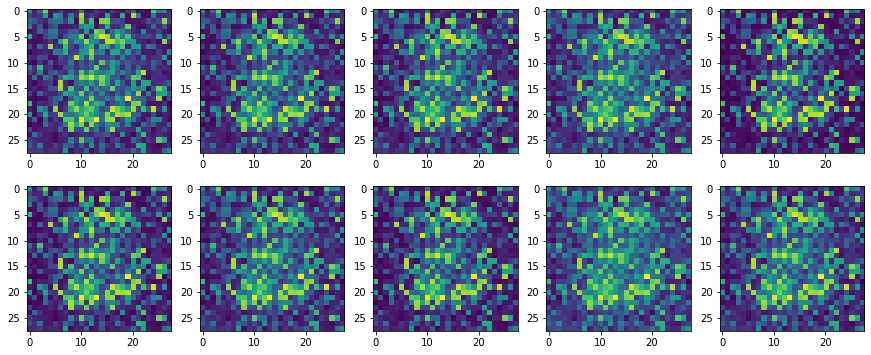

In [54]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

- 결과를 보니 아마도 10 epoch의 학습 만으로는 좋은 결과를 기대할 수 없나봅니다.
- 위 구현을 그대로 500 epoch 학습한 가중치를 아래에 첨부했으니 한번 사용해 봅시다.
- 첨부된 파일(GAN_500.zip)을 다운로드하여 아래와 같이 작업환경을 구성해 주세요.

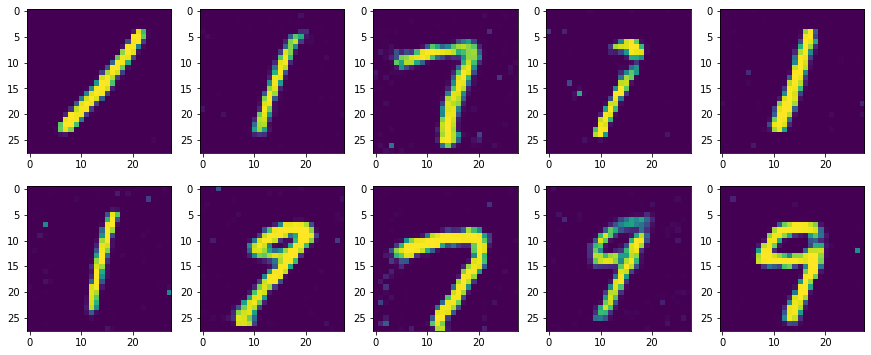

In [55]:
import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

- 위에 보이는 10개의 결과 이미지는 서로 다른 숫자들이 시각화 되었을 것입니다 (아닐수도 있습니다).
- 이러한 방법으로는 내가 원하는 특정 숫자 하나를 출력하기 위해 수많은 입력을 넣어야 할 수 있습니다. 내가 원하는 숫자를 바로 얻어내기 위해 아래에서 cGAN을 학습시켜 봅시다.



## cGAN으로 MNIST 학습하기
- 이전 단계에서 구성한 GeneratorCGAN 및 DiscriminatorCGAN 모델 클래스를 이용합니다.
- 위에서 실행했던 GAN 학습처럼 약간의 학습으로는 제대로 된 생성 결과를 얻을 수 없을테니 이번에는 연습삼아 1 epoch만 학습시켜 보겠습니다.

In [56]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:4.723824977874756, D:0.011291508562862873
[1/1 EPOCHS, 199 ITER] G:4.054514408111572, D:0.027001116424798965
[1/1 EPOCHS, 299 ITER] G:4.081931114196777, D:0.06050935760140419
[1/1 EPOCHS, 399 ITER] G:3.8994076251983643, D:0.04768110811710358


- 학습 과정에서 Generator 및 Discriminator에 레이블 정보만 추가로 입력했다는 점을 제외하면 위에서 학습한 GAN과 큰 차이는 없습니다.
- 위 코드로 짧게나마 학습시켜봤는데, 충분한 학습이 되기엔 더 많은 시간을 투자해야 합니다.
- 뒤에서 학습해야 할 것들이 많이 남아있으니, 시간을 아끼기 위해 위 코드로 500 epoch 학습한 가중치를 아래에 첨부했습니다.

- 아래 코드의 가장 윗줄에 있는 number라는 변수에 숫자를 할당하지 않았습니다.
- number에 0~9 사이의 숫자 중 생성하길 원하는 숫자를 입력해 주시고 아래 코드를 실행시켜봅시다.
- 경고메시지가 출력된다면 그냥 무시하셔도 됩니다.

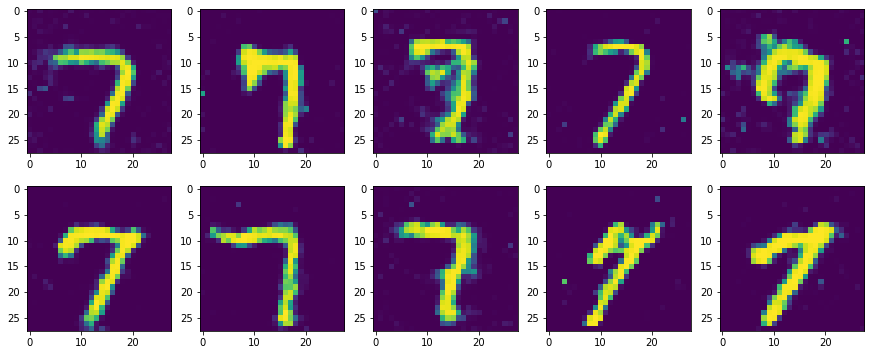

In [57]:
number = 7 # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

- 출력된 10개 시각화 결과는 어떤가요? 아마도 number에 입력한 숫자에 해당하는 손글씨가 시각화되었을 것입니다.
- cGAN을 사용해 조건을 주고 학습하면 이렇게 특정한 숫자를 만들어내기가 훨씬 쉬워졌습니다.😆

# GAN의 입력에 이미지를 넣는다면? Pix2Pix
- 지금까지 cGAN에 대해 알아보고 실험해보면서, 작은 조건만으로 우리가 원하는 클래스의 이미지를 생성할 수 있음을 확인했습니다.
- 만약 입력자체가 조건이 된다면 어떨까요? cGAN과 같이 클래스 레이블 등의 조건을 함께 입력하는 것이 아니라, 조금 더 자세하게 내가 원하는 이미지를 얻기 위해 이미지를 조건으로 줄 수 없을까요?
- 이번에 소개드릴 Pix2Pix는 기존 노이즈 입력을 이미지로 변환하는 일반적인 GAN을 넘어 이미지를 입력으로 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN 모델입니다.

- Pix2Pix를 제안한 논문의 제목은 Image-to-Image Translation with Conditional Adversarial Networks 로 하고자 하는 바가 제목에 그대로 담겨 있습니다.
- Conditional Adversarial Networks로 Image-to-Image Translation을 수행한다는 뜻이죠.
- Conditional Adversarial Networks는 이전 까지 알아봤던 cGAN과 같은 구조를 말하는 것인데, Image-to-Image Translation이란 단어는 무엇을 뜻하는 걸까요?
- 아래 Pix2Pix 논문에서 수행한 결과를 먼저 살펴봅시다.

- 이 후 표기되는 이미지에 대한 출처가 명시되지 않은 경우, Pix2Pix 논문에서 가져왔음을 미리 알려드립니다.
- - Image-to-Image Translation은 말 그대로 이미지 간 변환을 말합니다.😅
- 위 결과의 첫번째 [Labels to Street Scene] 이미지는 픽셀별로 레이블 정보만 존재하는 segmentation map을 입력으로 실제 거리 사진을 생성해 내었고, 이 외에 흑백 사진을 컬러로 변환하거나, 낮에 찍은 사진을 밤에 찍은 사진으로 변환하거나, 가방 스케치를 이용해 채색된 가방을 만들기도 합니다.
- 한 이미지의 픽셀에서 다른 이미지의 픽셀로(pixel to pixel) 변환한다는 뜻에서 Pix2Pix라는 이름으로 불립니다.
- 이 구조는 최근 활발하게 연구 및 응용되는 GAN 기반의 Image-to-Image Translation 작업에서 가장 기초가 되는 연구입니다.
- 노이즈와 레이블 정보를 함께 입력했던 cGAN은 fully-connected 레이어를 연속적으로 쌓아 만들었지만, 이미지 변환이 목적인 Pix2Pix는 이미지를 다루는데 효율적인 convolution 레이어를 활용합니다. GAN 구조를 기반으로 하기 때문에 크게 Generator와 Discriminator 두 가지 구성 요소로 이루어집니다.

## Pix2Pix (Generator)
- Generator는 어떠한 이미지를 입력 받아 변환된 이미지를 출력하기 위해 사용됩니다.
- 여기서 입력 이미지와 변환된 이미지의 크기는 동일해야 하며, 이러한 문제에서 흔히 사용되는 구조는 아래 그림과 같은 Encoder-Decoder 구조입니다.

- Encoder에서 입력 이미지(x)를 받으면 단계적으로 이미지를 down-sampling하면서 입력 이미지의 중요한 representation을 학습합니다.
- Decoder에서는 이를 이용해 반대로 다시 이미지를 up-sampling하여 입력 이미지와 동일한 크기의 변환된 이미지(y)를 생성해냅니다.
- 이러한 과정은 모두 convolution 레이어로 진행되며, 레이어 내의 수많은 파라미터를 학습하여 잘 변환된 이미지를 얻도록 합니다.
- 여기서 한 가지 짚고 넘어갈 부분은, Encoder의 최종 출력은 위 그림 중간에 위치한 가장 작은 사각형이며, bottleneck 이라고도 불리는 이 부분은 입력 이미지(x)의 가장 중요한 특징만을 담고 있습니다.
- 과연 이 중요하지만 작은 특징이 변환된 이미지(y)를 생성하는데 충분한 정보를 제공할까요?
- 이와 같은 점을 보완하기 위해 논문에서는 Generator 구조를 하나 더 제안합니다.
- 아래 그림과 같은 U-Net 구조 입니다.
- 위에서 살펴본 단순한 Encoder-Decoder로 구성된 Generator와 다른 점은, 각 레이어마다 Encoder와 Decoder가 연결(skip connection)되어 있다는 것입니다.
- Decoder가 변환된 이미지를 더 잘 생성하도록 Encoder로 부터 더 많은 추가 정보를 이용하는 방법이며,
- 이러한 U-Net 구조의 Generator를 사용해 아래와 같이 단순한 Encoder-Decoder 구조의 Generator를 사용한 결과에 비해 비교적 선명한 결과를 얻을 수 있었습니다.
- 여기서 U-Net은 이전에 segmentation 작업을 위해 제안된 구조입니다. U-Net에 대한 자세한 사항은 이번 노드의 학습 범위를 벗어나므로 아래에 잘 정리된 자료를 첨부합니다.

## Pix2Pix (Loss Function)
- 예상컨데 위 Generator 구조를 보면서 한번쯤 생각해 보셨을 것 같은 사항으로는 "Generator만으로도 이미지 변환이 가능하지 않을까?" 입니다.
- 생각 안해보셨다면 지금 한번 생각해봅시다.
- 물론, 가능합니다. AutoEncoder 형태의 접근은 Generator만으로 이미지 변환을 진행합니다.
- 당연하게도 변환하고자 하는 이미지를 Encoder에 입력 하여 Decoder의 출력으로 변환된 이미지를 얻을 수 있습니다.
- 출력된 이미지와 실제 이미지의 차이로 L2(MSE), L1(MAE) 같은 손실을 계산한 후 이를 역전파하여 네트워크를 학습 시키면 되겠죠.
- 이미지 변환이 가능은 하지만 문제는 변환된 이미지의 품질입니다.
- 아래 사진의 L1이라 써있는 결과가 Generator 만을 사용해 변환된 이미지와 실제 이미지 사이의 L1 손실을 이용해 만들어낸 결과입니다.
- L1 이라 쓰여있는 Generator만으로 생성된 결과는 매우 흐릿합니다. 이미지를 변환하는데 L1(MAE)이나 L2(MSE) 손실만을 이용해서 학습하는 경우 이렇게 결과가 흐릿해지는 경향이 있습니다. Generator가 단순히 이미지의 평균적인 손실만을 줄이고자 파라미터를 학습하기 때문에 이러한 현상이 불가피합니다.
- 반면 위 그림의 cGAN이라 쓰여진 GAN 기반의 학습방법은 비교적 훨씬 더 세밀한 정보를 잘 표현하고 있습니다.
- Discriminator를 잘 속이려면 Generator가 (Ground truth라고 쓰여진 이미지 같이) 진짜 같은 이미지를 만들어야 하기 때문이죠.
- 논문에서는 L1손실과 GAN 손실을 같이 사용하면 더욱 더 좋은 결과를 얻을 수 있다고 합니다 (위 그림의 L1+cGAN).

## Pix2Pix (Discriminator)
- 위 결과에서 보듯 실제 같은 이미지를 얻기 위해서는 GAN의 학습 방법을 이용해야 하며, 위에서 설명한 Generator를 발전시킬 서포터이자 경쟁자, Discriminator가 필요하겠죠. 혹시 이전에 다뤘던 DCGAN의 Discriminator 기억하시나요? 아래 그림은 DCGAN의 Discriminator를 나타냅니다.
- DCGAN의 Discriminator는 생성된 가짜이미지 혹은 진짜이미지를 하나씩 입력받아 convolution 레이어를 이용해 점점 크기를 줄여나가면서, 최종적으로 하나의 이미지에 대해 하나의 확률 값을 출력했습니다. Pix2Pix는 이 과정에서 의문을 갖습니다.
- 하나의 전체 이미지에 대해 하나의 확률 값만을 도출하는 것이 진짜 혹은 가짜를 판별하는 데 좋은 것일까?
- Pix2Pix는 이러한 의문점을 가지고 아래 그림과 같은 조금 다른 방식의 Discriminator를 사용합니다.
- 위 그림은 Pix2Pix에서 사용되는 Discriminator를 간략하게 나타냅니다. 하나의 이미지가 Discriminator의 입력으로 들어오면, convolution 레이어를 거쳐 확률 값을 나타내는 최종 결과를 생성하는데, 그 결과는 하나의 값이 아닌 여러 개의 값을 갖습니다 (위 그림의 Prediction은 16개의 값을 가지고 있습니다).
- 위 그림에서 입력이미지의 파란색 점선은 여러 개의 출력 중 하나의 출력을 계산하기 위한 입력이미지의 receptive field 영역을 나타내고 있으며, 전체 영역을 다 보는 것이 아닌 일부 영역(파란색 점선)에 대해서만 진짜/가짜를 판별하는 하나의 확률 값을 도출한다는 것입니다.
- 이런 방식으로 서로 다른 영역에 대해 진짜/가짜를 나타내는 여러 개의 확률 값을 계산할 수 있으며 이 값을 평균하여 최종 Discriminator의 출력을 생성합니다. 이러한 방법은 이미지의 일부 영역(patch)을 이용한다고 하여 PatchGAN이라고 불립니다. 일반적으로 이미지에서 거리가 먼 두 픽셀은 서로 연관성이 거의 없기 때문에 특정 크기를 가진 일부 영역에 대해서 세부적으로 진짜/가짜를 판별하는 것이 Generator로 하여금 더 진짜 같은 이미지를 만들도록 하는 방법입니다.
- 아래 그림은 (위 그림의 파란색 점선같은) 판별 영역을 다양한 크기로 실험하여 그 결과를 보여줍니다.
- 마지막에 보이는 286x286이라 적힌 이미지는 DCGAN의 Discriminator와 같이 전체 이미지에 대해 하나의 확률값을 출력하여
- 진짜/가짜를 판별하도록 학습한 결과입니다 (입력 이미지 크기가 286x286 입니다).
- 70x70 이미지는 Discriminator입력 이미지에서 70x70 크기를 갖는 일부 영역에 대해서 하나의 확률값을 출력한 것이며,
- 16x16, 1x1로 갈수록 더 작은 영역을 보고 각각의 확률값을 계산하므로 Discriminator의 출력 값의 개수가 더 많습니다.
- 위 4개의 이미지를 살펴보면, 너무 작은 patch를 사용한 결과(1x1, 16x16)는 품질이 좋지 않으며, 70x70 patch를 이용한 결과가
- 전체 이미지를 사용한 결과(286x286)보다 조금 더 사실적인 이미지를 생성하므로 PatchGAN의 사용이 성공적이라고 볼 수 있을 것 같습니다.
- 지금까지 Pix2Pix의 Generator와 Discriminator, Loss function을 구성하는 기본 아이디어들에 대해서 간략하게 알아봤습니다. 다음 단계부터는 Pix2Pix를 구현하면서 더 자세히 이해해봅시다.

# Segmentation map 도로 이미지 (1) 데이터 준비하기
- 이번에는 앞서 알아본 pix2pix 모델에 대해서 직접 구현하고 실험해봅시다. 사용해볼 데이터셋은 Sketch2Pokemon이라는 데이터셋입니다.
- Sketch2Pokemon info
- 위 출처에는 학습용 데이터 셋에 830개의 이미지가 있으며, 각 (256x256) 크기의 이미지 쌍이 나란히 붙어 (256x512) 크기의 이미지로 구성되어 있다고 합니다.
아래 링크에서 다운로드해서 직접 확인해봅시다. (위 출처에서 학습용 데이터셋만 따로 가져왔습니다)

In [1]:
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings("ignore")
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


- 출처의 내용과 같이 830개 이미지가 있음을 확인할 수 있습니다.

- 이번에는 아래 코드를 이용해 각각의 이미지들이 어떻게 생겼는지 확인해 봅시다. 학습용 데이터셋에서 임의로 6장을 선택하여 시각화합니다.



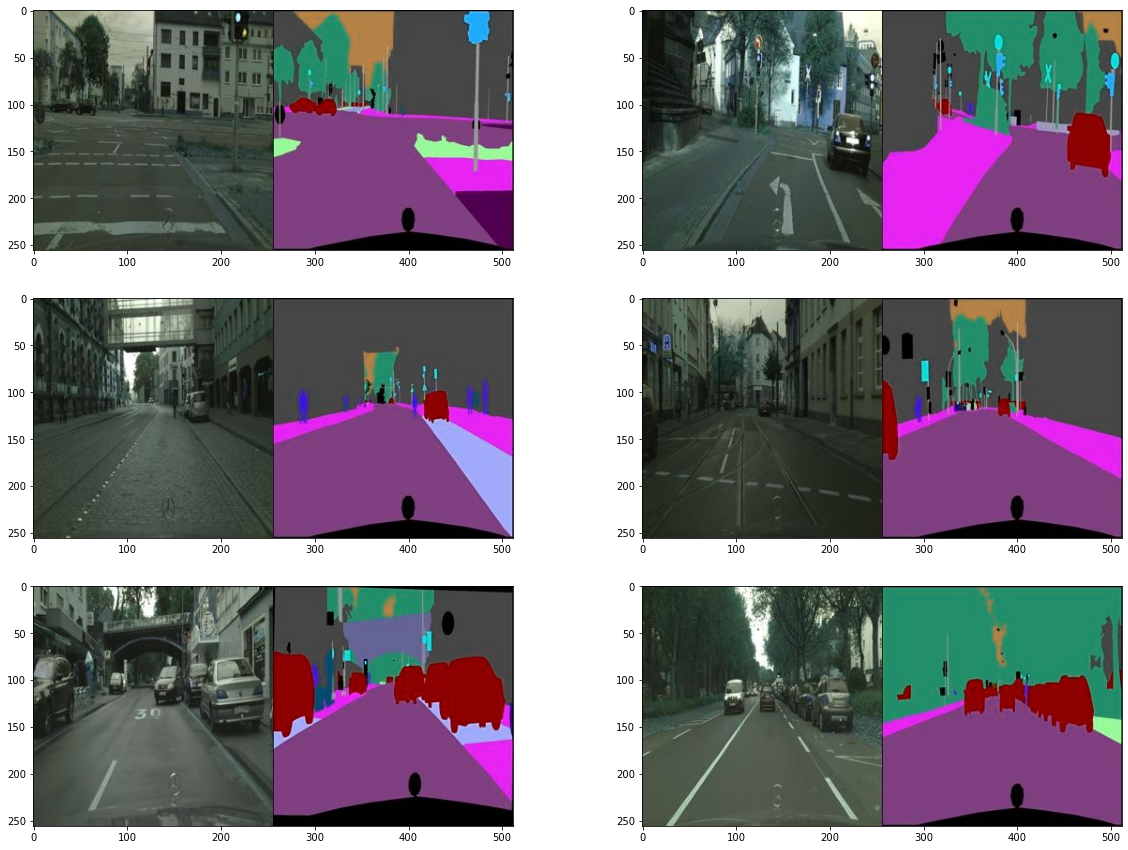

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

- 하나의 이미지에 포켓몬 스케치와 실제 포켓몬 이미지가 함께 포함되어 있음을 확인할 수 있습니다.
- 위 코드를 여러 번 반복 실행해 보면 일부는 제대로 스케치 되지 않은 이미지도 확인할 수 있습니다.
- 출처를 확인해보니 직접 그려서 만든 데이터셋이 아닌 스케치 생성 모델을 이용해서 만들었다고 하네요 😅

- 이미지를 하나 열어 아래와 같이 크기를 확인해 보겠습니다.

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


- (256, 512, 3)으로 확인되었습니다. 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용하면 될 것 같네요.
- 아래 코드로 이미지를 나누어 봅시다.

In [4]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

- 위와 같이 두개 이미지로 나누었습니다. 첫 번째 스케치를 다음 단계에서 구성할 Pix2Pix 모델에 입력하여 두 번째 그림과 같은 채색된 이미지를 생성하는 것이 이번 단계의 목표입니다.

- 앞서 살펴봤듯이 학습에 사용할 수 있는 데이터의 수는 약 800개 뿐입니다.
- 학습에 사용하는 데이터의 다양성을 높이기 위해 아래 코드와 같이 여러 augmentation 방법을 적용해 보겠습니다.

In [62]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


- apply_augmentation 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러가지 연산을 두 이미지에 동일하게 적용합니다.
- 입력된 이미지에 어떠한 과정이 적용되는지 위 코드를 보면서 아래 퀴즈를 풀어봅시다.
- 위에서 정의한 apply_augmentation 함수에 두 이미지가 입력되면 어떠한 과정을 거치는지 순서대로 적어주세요.
    1. 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
    - 1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
    - 2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop) 
    - 3.의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
    - 4.의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down) 
    - 5.의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)
    
    
- 위와 같이 구성한 함수를 데이터에 적용해 시각화 해봅시다.

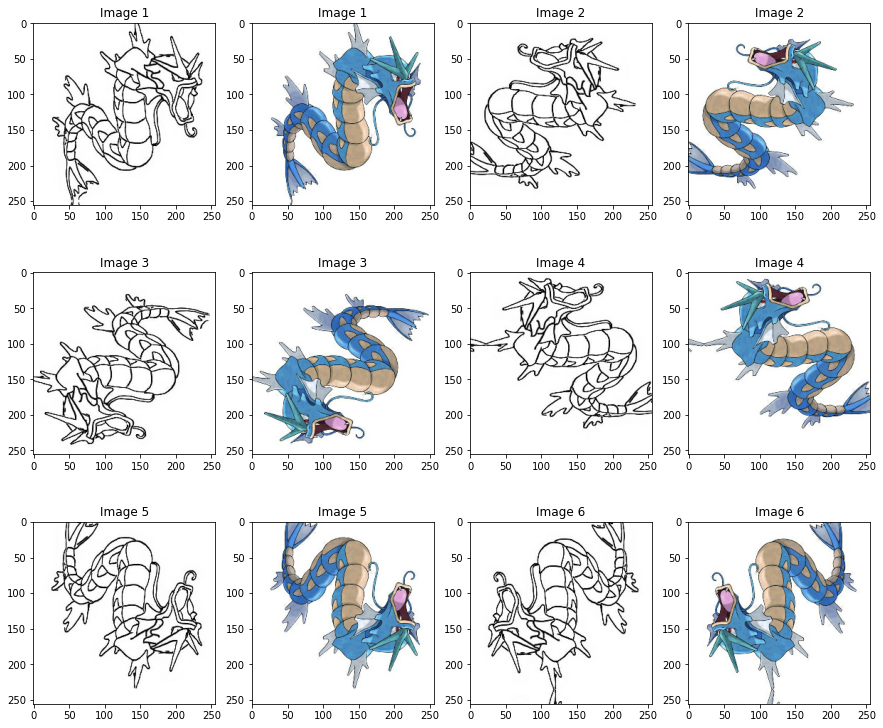

In [63]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

- 매우 다양한 이미지가 생성됩니다. 여기서 사용한 augmentation 방법 외에 더 많은 방법을 활용한다면 더욱 더 다양한 데이터셋을 만들어 좋은 일반화 결과를 기대해 볼 수 있습니다.😆

- 마지막으로 위 과정들을 학습 데이터에 적용하며, 잘 적용 되었는지 하나의 이미지만 시각화하여 확인해 보겠습니다.

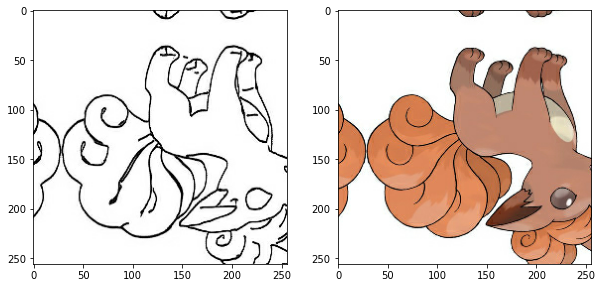

In [64]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# 난 스케치를 할테니 너는 채색을 하거라 (2) Generator 구성하기
- 이제부터 본격적으로 Pix2Pix 구조를 구현합니다. 앞서 cGAN 구현과 같이 Tensorflow의 Subclassing 방법을 이용해 모델을 만들겠습니다.

- (주의) 커널 메모리를 체크해 주세요!
- 이전 모델이 메모리에 로드되어 있는 상태에서 pix2pix 모델을 함께 학습하면 메모리 오류가 발생할 수도 있습니다. 메모리가 충분하지 않다면 이 시점에 커널 재시작 후 진행할 것을 권합니다.

## Generator의 구성요소 알아보기
- 먼저, pix2pix 논문에서 Generator를 구성하는데 필요한 정보를 아래에 가져왔습니다. 한번 읽어보시고 아래 질문에 답해봅시다.

![title](paper_g.png)

- 논문에서 표기한 encoder의 "C64"는 어떠한 하이퍼파라미터를 가진 레이어들의 조합을 나타내나요?
    - 64개의 4x4 필터에 stride 2를 적용한 Convolution → 0.2 slope의 LeakyReLU (위 논문의 아래 단락에 BatchNorm을 사용하지 않는다고 쓰여 있습니다)

- 논문에서 표기한 decoder의 "CD512"는 어떠한 하이퍼파라미터를 가진 레이어들의 조합을 나타내나요?
    - 512개의 4x4 필터에 stride 2를 적용한 (Transposed) Convolution → BatchNorm → 50% Dropout → ReLU
    
- 아마도 위 두 개의 질문에 잘 답하셨다면, Generator를 구성하는데 필요한 레이어들은 대략적으로 숙지하셨으리라 생각됩니다.
- 이번에는 아래와 같이 보기 쉽게 표현한 그림을 통해 Generator의 전체 구조를 머리 속에 조금 더 자세히 그려봅시다.

![title](refer_g.max-800x600.png)

- 위 그림에서 ENCODE 또는 DECODE라고 쓰인 각각의 블럭을 기준으로 양쪽에 쓰인 입출력 크기에 집중해주세요.
- "in"이라고 쓰여진 입력 부분부터 윗줄의 화살표를 쭉 따라가면 계산된 결과의 (width, height) 크기가 점점 절반씩 줄어들며 최종적으로 (1,1)이 되고,
- 채널의 수는 512까지 늘어나는 것을 확인할 수 있습니다.
- 처음 입력부터 시작해서 (1,1,512) 크기를 출력하는 곳까지가 Encoder 부분 입니다.

- 이어서 아랫줄 화살표를 따라가면 (width, height) 크기가 점점 두 배로 늘어나 다시 (256, 256) 크기가 되고, 채널의 수는 점점 줄어들어 처음 입력과 같이 3채널이 됩니다.
- (1,1,512)를 입력으로 최종 출력까지의 연산들이 Decoder 부분입니다.

## Generator 구현하기
- 위 정보들을 토대로 여러분의 머릿속에 희미하게 그려진 Generator의 Encoder 부분을 구현하겠습니다.
- 먼저 위 논문에서 "C64", "C128" 등으로 쓰여진 것과 같이 "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 아래와 같이 하나의 레이어로 만들었습니다.

In [65]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


- __init__() 메서드에서 n_filters, use_bn를 설정하여 사용할 필터의 개수와 BatchNorm 사용 여부를 결정 할 수 있습니다.
- 이외 Convolution 레이어에서 필터의 크기(=4) 및 stride(=2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정했습니다.
- Encoder에 사용할 기본 블록을 구성했으니 이 블록을 여러 번 가져다 사용하면 아래와 같이 쉽게 Encoder를 구성할 수 있습니다.

In [66]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


- 각 블록을 거치면서 사용할 필터의 개수를 filters라는 리스트에 지정해 두었으며, blocks이라는 리스트에는 사용할 블록들을 정의해 넣어두고, call() 메서드에서 차례대로 블록들을 통과합니다.
- 앞서 퀴즈로 알아본 것 처럼 Encoder 첫번째 블록에서는 BatchNorm을 사용하지 않습니다.
- get_summary는 레이어가 제대로 구성되었는지 확인하기 위한 용도로 따로 만들어 놓았습니다.
- 위에서 구성한 Encoder에 (256,256,3) 크기의 데이터를 입력했을 때, 어떤 크기의 데이터가 출력되는지 살펴봅시다. 만들어 놓은 get_summary 메서드를 바로 불러오시면 됩니다.

In [67]:
Encoder().get_summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block_40 (EncodeBlock (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_41 (EncodeBlock (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_42 (EncodeBlock (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_43 (EncodeBlock (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_44 (EncodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_45 (EncodeBlock (None, 4, 4, 512)       

- 블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력됨을 확인 할 수 있습니다.

- 이번엔 Decoder를 구현합니다. Encoder와 마찬가지로 사용할 기본 블록을 정의하고, 이 블록을 여러번 반복하여 아래와 같이 Decoder를 만들겠습니다.

In [68]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


- 처음 세 개의 블록에서만 Dropout을 사용했으며, 마지막 convolution에는 3개의 필터를 사용해 출력하는 것을 확인할 수 있습니다.
- 마찬가지로 (1,1,512) 크기의 데이터가 입력되었을 때, 어떤 크기가 출력되는지 확인해봅시다.

In [69]:
Decoder().get_summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block_35 (DecodeBlock (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_36 (DecodeBlock (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_37 (DecodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_38 (DecodeBlock (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_39 (DecodeBlock (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_40 (DecodeBlock (None, 64, 64, 128)     

- (width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256,256,3) 크기로 알맞게 출력되었습니다.

- 위에서 구성한 Encoder와 Decoder를 연결시키면 Encoder에서 (256,256,3) 입력이 (1,1,512)로 변환되고, Decoder를 통과해 다시 원래 입력 크기와 같은 (256,256,3)의 결과를 얻을 수 있겠군요. 스케치를 입력으로 이런 연산 과정을 통해 채색된 이미지 출력을 얻을 수 있습니다.
- 아래 코드와 같이 tf.keras.Model을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성해봅시다.



In [70]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_3 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_3 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


Generator를 잘 작동시키기 위해서는 약 4000만개의 파라미터를 잘 학습시켜야 하네요😅

In [71]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


# 난 스케치를 할테니 너는 채색을 하거라 (3) Generator 재구성하기
- 지금까지 Encoder와 Decoder를 연결시켜 Generator를 만들어 봤습니다.
- 하지만 앞서 설명드린 것 처럼 Pix2Pix의 Generator 구조는 아래 그림처럼 두 가지를 제안했습니다.
- 아래 그림으로 다시 한번 봅시다.

- 위 그림에서 각 구조 아래에 표시된 이미지는 해당 구조를 Generator로 사용했을 때의 결과입니다.

- 단순한 Encoder-Decoder 구조에 비해 Encoder와 Decoder 사이를 skip connection으로 연결한 U-Net 구조를 사용한 결과가 훨씬 더 실제 이미지에 가까운 품질을 보입니다.

- 이전 단계에서 구현했던 Generator는 위 그림의 Encoder-decoder 구조입니다.
- Encoder에서 출력된 결과를 Decoder의 입력으로 연결했고, 이 외에 추가적으로 Encoder와 Decoder를 연결시키는 부분은 없었습니다.
- 더 좋은 결과를 기대하기 위해 이전에 구현했던 것들을 조금 수정하여 위 그림의 U-Net 구조를 만들고 실험해봅시다.
- (아래 단락 부터는 두 가지 구조를 각각 "Encoder-Decoder Generator" 및 "U-Net Generator"라는 용어로 구분하여 사용하겠습니다)

- 먼저 Encoder 및 Decoder에 사용되는 기본적인 블록은 이전에 아래 코드와 같이 구현했었습니다.

In [72]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


- 여기서 특별히 수정해야 할 부분은 없습니다. 그대로 가져다가 사용하겠습니다.

- 정의된 블록들을 이용해 한 번에 U-Net Generator를 정의해 보겠습니다. 아래 모델의 __init__() 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의해 놓고,
- call()에서 forward propagation 하도록 합니다. 이전 구현에는 없었던 skip connection이 call() 내부에서 어떻게 구현되었는지 잘 확인해봅시다.

- 먼저, __init__() 에서 정의된 encode_blocks 및 decode_blocks가 call() 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행합니다.
- 이 때, Encoder와 Decoder 사이의 skip connection을 위해 features 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담았습니다.
- 이 후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데,
- features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용됩니다.

- 아래 질문에 답하면서 조금 더 자세히 이해해봅시다.
- 위 코드의 call() 내에서 ' features = features[:-1]' 는 왜 필요할까요?
    - Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있는데, Encoder의 마지막 출력(feature리스트 의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아닙니다.
- 위 코드의 call() 내의 Decoder 연산 부분에서 features[::-1] 는 왜 필요할까요?
    - Skip connection은 Encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, Encoder 내 두 번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는.. 등 대칭을 이룹니다(맨 위 U-Net 구조 사진 참고). 
    - features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례대로 사용하기 위해서 features의 역순으로 연결합니다.

- 아래와 같은 데이터 A, B가 있을 때, 
    - 데이터 A 크기 : (32,128,128,200) #(batch, width, height, channel)
    - 데이터 B 크기 : (32,128,128,400) #(batch, width, height, channel)
    - 여기서 사용되는 skip connection은 layers.Concatenate() 결과의 크기는 무엇일까요?
    - (128,128,600)
    - layers.Concatenate() 내에 별다른 설정이 없다면 가장 마지막 축(채널 축)을 기준으로 서로 연결됩니다.    

- 이제야 Generator 구현이 끝났습니다.

- 마지막으로 완성된 U-Net 구조 Generator 내부의 각 출력이 적절한지 아래 코드로 확인해봅시다.

In [73]:
UNetGenerator().get_summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_56 (EncodeBlock)   (None, 128, 128, 64) 3072        input_11[0][0]                   
__________________________________________________________________________________________________
encode_block_57 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_56[0][0]            
__________________________________________________________________________________________________
encode_block_58 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_57[0][0]            
______________________________________________________________________________________

- 이전 Encoder-Decoder Generator 구조에서 학습해야 할 파라미터는 약 4000만개 였는데, Skip connection을 추가한 U-Net Generator의 파라미터는 약 5500만개로 꽤나 많이 늘어났습니다.
- U-Net Generator의 파라미터가 늘어난 곳은 Encoder와 Decoder 중 어디일까요?
- 또한, 두 종류의 Generator 구조에서 동일한 수의 convolution 레이어를 사용했는데, 구체적으로 어느 부분에서 파라미터가 늘어났을까요?
    - U-Net Generator의 Decoder 구조 내 파라미터가 많아졌습니다. 이 부분의 각 convolution 레이어에서 사용된 필터의 수는 두 종류의 Decoder에서 동일하지만, 그 크기가 다릅니다. 
    - 예를 들어, 이전 Decoder 블록의 출력의 크기가 (16,16,512)라면,
    - Encoder-decoder Generator의 경우, Decoder의 다음 블록에서 계산할 convolution의 필터 크기는 4x4x512 입니다.
    - U-Net Generator의 경우, Encoder 내 블록 출력이 함께 연결되어 Decoder의 다음 블록에서 계산할 convolution의 필터 크기는 4x4x(512+512) 입니다.
- 정리하면, U-Net Generator에서 사용한 skip-connection으로 인해 Decoder의 각 블록에서 입력 받는 채널 수가 늘어났고,
- 이에 따라 블록 내 convolution 레이어에서 사용하는 필터 크기가 커지면서 학습해야 할 파라미터가 늘어났습니다.

# 난 스케치를 할테니 너는 채색을 하거라 (4) Discriminator 구성하기
- Generator만으로 좋은 결과를 도출하기에는 부족합니다. 조금 더 사실적인 이미지를 생성하기 위한 Pix2Pix를 완성시키기 위해서는 Discriminator가 필요합니다.
- 이번 단계에서 Discriminator를 만들어 Pix2Pix 구조를 완성시켜 봅시다.

## Discriminator의 구성요소 알아보기
- Generator를 만들기 전에 봤듯이 먼저 Pix2Pix 논문에서 Discriminator를 구성하는데 필요한 정보를 아래에 가져왔습니다.

![title](paper_d.png)

- Generator의 구성 요소와 똑같이 "C64" 등으로 표기되어있습니다.
- 진짜 및 가짜 이미지를 판별하기 위해 최종 출력에 sigmoid를 사용하는 것을 제외하면 특별한 변경 사항은 없는 것 같습니다.

- 이어서 아래의 보기 쉽게 표현한 그림을 통해 Discriminator의 구조를 머리 속에 조금 더 자세히 그려봅시다.

![title](refer_d.max-800x600.png)

- Discriminator는 2개 입력(위 그림의 "in", "unknown")을 받아 연결(CONCAT)한 후, ENCODE 라고 쓰인 5개의 블록을 통과합니다.
- 이 중 마지막 블록을 제외한 4개 블록은 위 논문에서 표기된 "C64-C128-C256-C512"에 해당하며, 마지막은 1(채널)차원 출력을 위한 블록이 추가되었습니다.

- 최종적으로 출력되는 크기는 (30,30,1) 이며, 위 그림의 출력 이전의 2개의 ENCODE 블록을 보면 각각의 출력 크기가 32, 31, 30으로 1씩 감소하는 것을 알 수 있습니다.
- Generator에서도 사용했던 2 stride convolution에 패딩을 이용하면 (width, height) 크기가 절반씩 감소할 것입니다.
- 1 stride convolution에 패딩을 하지 않는다면 (width, height) 크기는 (필터 크기가 4이므로) 3씩 감소할 텐데, 그림과 같이 1씩 감소하도록 하려면 무언가 다른 방법을 써야 할 것 같네요.🤔
- 이 부분이 지금 이해되지 않는다면 아래 코드에서 다시 다룰테니 우선 넘어갑시다.

- 추가적으로 위 그림에서 최종 출력 크기가 (30,30)이 되어야 하는 이유는 앞서 Discriminator에 대해 알아봤던 70x70 PatchGAN을 사용했기 때문입니다. 최종 (30,30) 출력에서 각 픽셀의 receptive field 크기를 (70,70)으로 맞추기 위해 Discriminator의 출력 크기를 (30,30) 크기로 강제로 맞추는 과정입니다.
- 이 부분에 대한 설명은 아래 참고 자료로 대신하겠습니다. (아래 글 마지막 부분에 언급합니다)

- Understanding PatchGAN
- 이 부분만 제외하면 전반적으로는 Generator보다 간단한 것 같습니다. 구현해봅시다.

## Discriminator 구현하기
마찬가지로 Discriminator에 사용할 기본적인 블록부터 만들겠습니다.



In [74]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


- __init__() 에서 필요한 만큼 많은 설정을 가능하게끔 했습니다.
- 필터의 수(n_filters), 필터가 순회하는 간격(stride), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad),
- BatchNorm의 사용 여부(use_bn), 활성화 함수 사용 여부(act)가 설정 가능합니다.

- 아래 질문에 답하면서 위 코드가 어떻게 동작하는지 생각해봅시다.
- 다음의 DiscBlock(n_filters=64, stride=1, custom_pad=True, use_bn=True, act=True) 설정으로 생성된 블록에 (width, height, channel) = (128, 128, 32) 크기가 입력된다면, 블록 내부에서 순서대로 어떠한 레이어를 통과하는지, 그리고 각 레이어를 통과했을 때 출력 크기는 어떻게 되는지 적어주세요.
    1. 패딩 레이어 통과 layers.ZeroPadding2D() → (130,130,32)  
    2. Convolution 레이어 통과 layers.Conv2D(64,4,1,"valid") → (127,127,64)  
    3. BatchNormalization 레이어 통과  layers.BatchNormalization() → (127,127,64)  
    4. LeakyReLU 활성화 레이어 통과 layers.LeakyReLU(0.2) → (127,127,64)
    
- 이전 Discriminator를 표현한 그림에서 마지막 2개 블록의 출력은 입력에 비해 (width, height) 크기가 1씩 감소한다는 것을 언급했었습니다.
- 1씩 감소시키기 위한 방법이 위 질문의 답이며, 이에 대해 자세히 설명해보겠습니다.

    1. (128,128,32) 크기의 입력이 layers.ZeroPadding2D()를 통과하면, width 및 height의 양쪽 면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어납니다. 출력 : (130,130,32)
    2. 패딩하지 않고 필터 크기 4 및 간격(stride) 1의 convolution 레이어를 통과하면 width 및 height 가 3씩 줄어듭니다. 이는 OutSize=(InSize+2∗PadSize−FilterSize)/Stride+1 의 식으로 계산할 수 있습니다. 채널 수는 사용한 필터 개수와 같습니다. 출력 : (127,127,64)
    3. 이 외 다른 레이어(BatchNorm, LeakyReLU)는 출력의 크기에 영향을 주지 않습니다.
- 간단하게 코드를 작성하여 각 출력의 크기가 맞는지 확인해 봅시다.

In [75]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_9 (ZeroPaddin (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_133 (Bat (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_81 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


- 이러한 코드와 비슷한 설정으로 (width, height) 크기를 1씩 감소시킬 수 있습니다. 마지막 2개 블록은 출력의 크기가 1씩 감소하므로 이런 방식을 적용하면 되겠습니다.

- Pix2Pix의 Discriminator가 70x70 PatchGAN을 사용하기 때문에 최종 출력을 (30,30) 크기로 맞추느라 위와 같이 조금 복잡한 과정을 설명했습니다.
- 사용할 기본적인 블록을 만들었으니 이를 이용해 바로 Discriminator를 만들어봅시다.

In [76]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


- __init__() 내부에서 사용할 블록들을 정의했는데, 이전의 구현들 처럼 (위 코드의 주석 처리된 부분과 같이) for loop로 간편하게 블록을 만들 수도 있지만,
- 쉽게 코드를 읽게 끔 총 6개 블록을 각각 따로 만들었습니다.
- 첫 번째 블록은 단순한 연결(concat)을 수행하며, Discriminator의 최종 출력은 sigmoid 활성화를 사용했습니다.
- 각 블록의 출력 크기가 알맞게 되었는지 아래 코드로 확인해봅시다.

In [77]:
Discriminator().get_summary()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_25 (Concatenate)    (None, 256, 256, 6)  0           input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
disc_block_20 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_25[0][0] 

- 두 개의 (256,256,3) 크기 입력으로 최종 (30,30,1) 출력을 만들었고, 아래의 Discriminator를 나타낸 그림과 각 출력 크기가 일치합니다.

![title](refer_d.max-800x600.png)

- 시험삼아 임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화해보겠습니다.

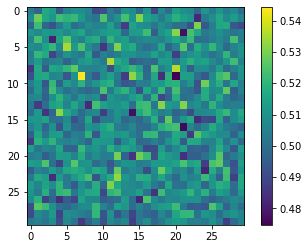

In [78]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

- 이전 PatchGAN에 대해 설명했던 것 처럼, 위 (30,30) 크기를 갖는 결과 이미지의 각 픽셀값은 원래 입력의 (70,70) 패치에 대한 분류 결과 입니다.
- 전체 입력의 크기가 (256,256) 이므로, 각각의 (70,70) 패치는 원래 입력상에서 많이 겹쳐있겠죠.
- 각각의 픽셀값은 sigmoid 함수의 결과값이므로 0~1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해내는데 사용합니다.

- 드디어 Pix2Pix를 구성하는 Generator와 Discriminator의 구현이 끝났습니다.
- 다음 단계에서 본격적인 모델 학습을 진행해 봅시다!

# 난 스케치를 할테니 너는 채색을 하거라 (5) 학습 및 테스트하기
- 이번 단계에서는 구현된 Generator와 Discriminator를 학습시켜보고, 스케치를 입력으로 채색된 이미지를 생성해 봅시다. 먼저 학습에 필요한 손실함수 부터 정의하겠습니다.
- 논문의 여러 실험 결과 중 손실함수 선택에 따른 결과의 차이는 아래와 같습니다.

![title](p2p_result_loss2.max-800x600.png)

- 레이블 정보만 있는 입력에 대해 여러 손실함수를 사용해 실제 이미지를 만들어 낸 결과는, 일반적인 GAN의 손실함수에 L1을 추가로 이용했을 때
- 가장 실제에 가까운 이미지를 생성해 냈습니다. 이번 실험에서도 두 가지 손실 함수를 모두 사용해 봅시다.


In [79]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅



- Generator 및 Discriminator의 손실 계산을 각각 정의했습니다.

    - Generator의 손실함수 (위 코드의 get_gene_loss)는 총 3개의 입력이 있습니다.
    - 이 중 fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용합니다.
    - 또한 L1 손실을 계산하기 위해 생성한 가짜이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산합니다.

    - Discriminator의 손실함수 (위 코드의 get_disc_loss)는 2개의 입력이 있으며, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값입니다.
    - Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교합니다.

- 사용할 optimizer는 논문과 동일하게 아래와 같이 설정합니다.



In [80]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅



- 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트 하는 과정은 아래와 같이 구현했습니다.

In [81]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


- 전반적인 학습 과정은 앞서 진행했었던 cGAN 학습과 크게 다르지 않습니다.
- 다만 위 코드의 gene_total_loss 계산 라인에서 최종 Generator 손실을 계산할 때, L1 손실에 100을 곱한 부분을 확인 하셨나요? (## 이 표시가 있는 부분을 확인해 주세요.) 논문에서는 Generator의 손실을 아래와 같이 정의했습니다.
    
![title](Generator_loss.png)    

- 위 식에서 λ는 학습 과정에서 L1 손실을 얼마나 반영할 것인지를 나타내며 논문에서는 λ=100 을 사용했습니다.

- 앞서 정의한 함수를 이용해서 학습을 진행합니다. 우선 10 epoch 학습해 봅시다.

In [91]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.1854                     
L1_loss:0.4904                     
Discriminator_loss:1.2460

EPOCH[1] - STEP[20]                     
Generator_loss:0.8864                     
L1_loss:0.2917                     
Discriminator_loss:1.2142

EPOCH[1] - STEP[30]                     
Generator_loss:1.0476                     
L1_loss:0.3189                     
Discriminator_loss:1.3749

EPOCH[1] - STEP[40]                     
Generator_loss:0.9881                     
L1_loss:0.2541                     
Discriminator_loss:1.0122

EPOCH[1] - STEP[50]                     
Generator_loss:1.5812                     
L1_loss:0.2416                     
Discriminator_loss:0.8710

EPOCH[1] - STEP[60]                     
Generator_loss:1.8158                     
L1_loss:0.2848                     
Discriminator_loss:0.5813

EPOCH[1] - STEP[70]                     
Generator_loss:1.1637                     
L1_loss:0.2547                    

EPOCH[3] - STEP[170]                     
Generator_loss:2.6317                     
L1_loss:0.2714                     
Discriminator_loss:0.4874

EPOCH[3] - STEP[180]                     
Generator_loss:3.3998                     
L1_loss:0.2624                     
Discriminator_loss:1.7796

EPOCH[3] - STEP[190]                     
Generator_loss:1.8778                     
L1_loss:0.2114                     
Discriminator_loss:0.4593

EPOCH[3] - STEP[200]                     
Generator_loss:2.1676                     
L1_loss:0.2320                     
Discriminator_loss:0.2184

EPOCH[4] - STEP[10]                     
Generator_loss:2.0236                     
L1_loss:0.2307                     
Discriminator_loss:0.6226

EPOCH[4] - STEP[20]                     
Generator_loss:0.2488                     
L1_loss:0.2104                     
Discriminator_loss:1.9006

EPOCH[4] - STEP[30]                     
Generator_loss:1.6653                     
L1_loss:0.2552                

EPOCH[6] - STEP[130]                     
Generator_loss:3.0803                     
L1_loss:0.2514                     
Discriminator_loss:0.4373

EPOCH[6] - STEP[140]                     
Generator_loss:1.5562                     
L1_loss:0.3083                     
Discriminator_loss:0.4565

EPOCH[6] - STEP[150]                     
Generator_loss:1.7044                     
L1_loss:0.2546                     
Discriminator_loss:0.7087

EPOCH[6] - STEP[160]                     
Generator_loss:1.0730                     
L1_loss:0.2435                     
Discriminator_loss:0.5515

EPOCH[6] - STEP[170]                     
Generator_loss:3.0690                     
L1_loss:0.3137                     
Discriminator_loss:1.2904

EPOCH[6] - STEP[180]                     
Generator_loss:2.6266                     
L1_loss:0.2775                     
Discriminator_loss:0.4066

EPOCH[6] - STEP[190]                     
Generator_loss:2.5682                     
L1_loss:0.2611             

EPOCH[9] - STEP[90]                     
Generator_loss:3.6174                     
L1_loss:0.2610                     
Discriminator_loss:0.4338

EPOCH[9] - STEP[100]                     
Generator_loss:1.0166                     
L1_loss:0.2057                     
Discriminator_loss:0.5914

EPOCH[9] - STEP[110]                     
Generator_loss:1.4100                     
L1_loss:0.2229                     
Discriminator_loss:0.7777

EPOCH[9] - STEP[120]                     
Generator_loss:0.9831                     
L1_loss:0.2167                     
Discriminator_loss:1.1101

EPOCH[9] - STEP[130]                     
Generator_loss:1.6884                     
L1_loss:0.2532                     
Discriminator_loss:0.2896

EPOCH[9] - STEP[140]                     
Generator_loss:2.3681                     
L1_loss:0.2807                     
Discriminator_loss:0.6587

EPOCH[9] - STEP[150]                     
Generator_loss:2.3642                     
L1_loss:0.2417              

- 아래 코드로 짧게나마 학습해 본 모델에 채색을 시켜봅시다. 아마 마음에 안들겁니다.. 😥

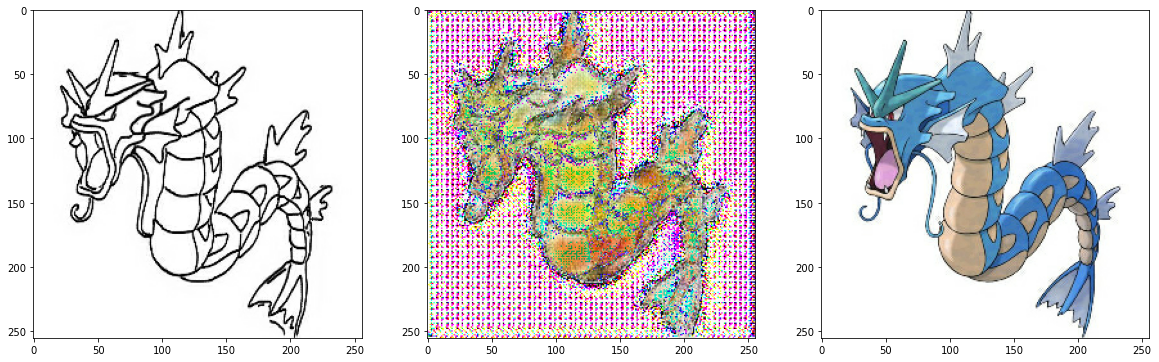

In [92]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

- 데이터셋을 제공한 출처를 보면, Pix2Pix로 128 epoch 학습 후 테스트 결과가 아래와 같다고 합니다.
- 이전 10 epoch 학습의 결과보다는 훨씬 낫지만, 조금 오래 학습했어도 채색해야 할 전체적인 색감 정도만 학습되며 아직까지 세부적으로는 제대로 채색되지 않다는 것을 확인할 수 있습니다.

![title](pokemon_result.max-800x600.png)

- 지금까지 꽤 많은 시간을 투자해서 Encoder-Decoder Generator, U-Net Generator, Discriminator의 구현까지 이해하느라 고생하셨습니다.
- 앞서 다뤘던 코드의 이해에 큰 어려움이 없었다면, 연습을 통해 이와 비슷한 구조의 모델들 또한 쉽게 구현할 수 있을 것입니다.
- (U-Net Generator를 구현했으니 원래 segmentation에 사용되었던 U-Net도 쉽게 구현할 수 있습니다!).

- 이번 학습을 통해서 여러분이 Pix2Pix 구조뿐만 아니라 CNN 기반의 어떠한 구조라도 자신을 갖고 구현을 시작할 수 있길 바랍니다.
- 마지막으로 다음 단계로 넘어가서 Pix2Pix를 이용한 프로젝트를 수행해봅시다.

In [40]:
EPOCHS = 200

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0160                     
L1_loss:0.4621                     
Discriminator_loss:1.1271

EPOCH[1] - STEP[20]                     
Generator_loss:1.0231                     
L1_loss:0.3299                     
Discriminator_loss:1.3675

EPOCH[1] - STEP[30]                     
Generator_loss:1.2699                     
L1_loss:0.3399                     
Discriminator_loss:1.1682

EPOCH[1] - STEP[40]                     
Generator_loss:1.2457                     
L1_loss:0.2526                     
Discriminator_loss:0.9581

EPOCH[1] - STEP[50]                     
Generator_loss:1.4900                     
L1_loss:0.3391                     
Discriminator_loss:0.6275

EPOCH[1] - STEP[60]                     
Generator_loss:1.6553                     
L1_loss:0.2851                     
Discriminator_loss:0.4581

EPOCH[1] - STEP[70]                     
Generator_loss:1.4952                     
L1_loss:0.2162                    

EPOCH[3] - STEP[170]                     
Generator_loss:0.4416                     
L1_loss:0.2268                     
Discriminator_loss:1.9264

EPOCH[3] - STEP[180]                     
Generator_loss:0.1530                     
L1_loss:0.2635                     
Discriminator_loss:2.3365

EPOCH[3] - STEP[190]                     
Generator_loss:2.1344                     
L1_loss:0.2214                     
Discriminator_loss:0.4929

EPOCH[3] - STEP[200]                     
Generator_loss:1.2546                     
L1_loss:0.2530                     
Discriminator_loss:0.4868

EPOCH[4] - STEP[10]                     
Generator_loss:0.6778                     
L1_loss:0.2304                     
Discriminator_loss:1.3839

EPOCH[4] - STEP[20]                     
Generator_loss:3.2667                     
L1_loss:0.2534                     
Discriminator_loss:0.9430

EPOCH[4] - STEP[30]                     
Generator_loss:0.1026                     
L1_loss:0.2358                

EPOCH[6] - STEP[130]                     
Generator_loss:2.4899                     
L1_loss:0.2820                     
Discriminator_loss:0.1595

EPOCH[6] - STEP[140]                     
Generator_loss:1.2860                     
L1_loss:0.2362                     
Discriminator_loss:0.5357

EPOCH[6] - STEP[150]                     
Generator_loss:2.9938                     
L1_loss:0.2518                     
Discriminator_loss:1.0831

EPOCH[6] - STEP[160]                     
Generator_loss:1.1299                     
L1_loss:0.2235                     
Discriminator_loss:1.3842

EPOCH[6] - STEP[170]                     
Generator_loss:1.2449                     
L1_loss:0.2173                     
Discriminator_loss:0.5863

EPOCH[6] - STEP[180]                     
Generator_loss:2.0352                     
L1_loss:0.2115                     
Discriminator_loss:0.4276

EPOCH[6] - STEP[190]                     
Generator_loss:2.1258                     
L1_loss:0.2507             

EPOCH[9] - STEP[90]                     
Generator_loss:1.3679                     
L1_loss:0.2271                     
Discriminator_loss:0.3918

EPOCH[9] - STEP[100]                     
Generator_loss:2.6091                     
L1_loss:0.2321                     
Discriminator_loss:0.1641

EPOCH[9] - STEP[110]                     
Generator_loss:3.8959                     
L1_loss:0.3113                     
Discriminator_loss:0.9098

EPOCH[9] - STEP[120]                     
Generator_loss:2.1767                     
L1_loss:0.2638                     
Discriminator_loss:0.2594

EPOCH[9] - STEP[130]                     
Generator_loss:1.4934                     
L1_loss:0.2352                     
Discriminator_loss:0.6075

EPOCH[9] - STEP[140]                     
Generator_loss:1.7723                     
L1_loss:0.2303                     
Discriminator_loss:0.2346

EPOCH[9] - STEP[150]                     
Generator_loss:2.1155                     
L1_loss:0.2354              

EPOCH[12] - STEP[50]                     
Generator_loss:1.7655                     
L1_loss:0.2257                     
Discriminator_loss:0.2484

EPOCH[12] - STEP[60]                     
Generator_loss:1.5043                     
L1_loss:0.2515                     
Discriminator_loss:0.4266

EPOCH[12] - STEP[70]                     
Generator_loss:2.5214                     
L1_loss:0.2633                     
Discriminator_loss:0.7732

EPOCH[12] - STEP[80]                     
Generator_loss:1.4429                     
L1_loss:0.2839                     
Discriminator_loss:0.6949

EPOCH[12] - STEP[90]                     
Generator_loss:1.0269                     
L1_loss:0.1949                     
Discriminator_loss:0.6464

EPOCH[12] - STEP[100]                     
Generator_loss:2.0723                     
L1_loss:0.2288                     
Discriminator_loss:0.5292

EPOCH[12] - STEP[110]                     
Generator_loss:0.1688                     
L1_loss:0.1959           

EPOCH[15] - STEP[10]                     
Generator_loss:2.8623                     
L1_loss:0.2377                     
Discriminator_loss:0.5715

EPOCH[15] - STEP[20]                     
Generator_loss:1.1575                     
L1_loss:0.3318                     
Discriminator_loss:0.5141

EPOCH[15] - STEP[30]                     
Generator_loss:1.5578                     
L1_loss:0.3006                     
Discriminator_loss:0.3174

EPOCH[15] - STEP[40]                     
Generator_loss:3.2718                     
L1_loss:0.2169                     
Discriminator_loss:2.0648

EPOCH[15] - STEP[50]                     
Generator_loss:1.3536                     
L1_loss:0.2093                     
Discriminator_loss:0.7006

EPOCH[15] - STEP[60]                     
Generator_loss:3.6250                     
L1_loss:0.1935                     
Discriminator_loss:1.3810

EPOCH[15] - STEP[70]                     
Generator_loss:3.5145                     
L1_loss:0.2844             

EPOCH[17] - STEP[170]                     
Generator_loss:1.4493                     
L1_loss:0.2143                     
Discriminator_loss:0.7122

EPOCH[17] - STEP[180]                     
Generator_loss:2.0469                     
L1_loss:0.2447                     
Discriminator_loss:0.3532

EPOCH[17] - STEP[190]                     
Generator_loss:2.8966                     
L1_loss:0.2528                     
Discriminator_loss:0.2690

EPOCH[17] - STEP[200]                     
Generator_loss:1.1920                     
L1_loss:0.2108                     
Discriminator_loss:0.5439

EPOCH[18] - STEP[10]                     
Generator_loss:2.7482                     
L1_loss:0.2465                     
Discriminator_loss:0.4388

EPOCH[18] - STEP[20]                     
Generator_loss:2.3062                     
L1_loss:0.2516                     
Discriminator_loss:0.8272

EPOCH[18] - STEP[30]                     
Generator_loss:0.8839                     
L1_loss:0.2587         

EPOCH[20] - STEP[130]                     
Generator_loss:0.7382                     
L1_loss:0.1993                     
Discriminator_loss:0.7674

EPOCH[20] - STEP[140]                     
Generator_loss:2.6070                     
L1_loss:0.2359                     
Discriminator_loss:1.6077

EPOCH[20] - STEP[150]                     
Generator_loss:0.8345                     
L1_loss:0.2108                     
Discriminator_loss:0.8948

EPOCH[20] - STEP[160]                     
Generator_loss:3.2019                     
L1_loss:0.1978                     
Discriminator_loss:0.5911

EPOCH[20] - STEP[170]                     
Generator_loss:1.1192                     
L1_loss:0.2609                     
Discriminator_loss:0.4753

EPOCH[20] - STEP[180]                     
Generator_loss:3.0685                     
L1_loss:0.2805                     
Discriminator_loss:0.9558

EPOCH[20] - STEP[190]                     
Generator_loss:3.7819                     
L1_loss:0.2134      

EPOCH[23] - STEP[90]                     
Generator_loss:1.4182                     
L1_loss:0.2266                     
Discriminator_loss:0.4127

EPOCH[23] - STEP[100]                     
Generator_loss:1.5234                     
L1_loss:0.2306                     
Discriminator_loss:0.3222

EPOCH[23] - STEP[110]                     
Generator_loss:1.1641                     
L1_loss:0.1978                     
Discriminator_loss:0.5090

EPOCH[23] - STEP[120]                     
Generator_loss:0.0441                     
L1_loss:0.2867                     
Discriminator_loss:3.4551

EPOCH[23] - STEP[130]                     
Generator_loss:1.7244                     
L1_loss:0.2383                     
Discriminator_loss:0.3988

EPOCH[23] - STEP[140]                     
Generator_loss:2.4692                     
L1_loss:0.2100                     
Discriminator_loss:1.4876

EPOCH[23] - STEP[150]                     
Generator_loss:1.2524                     
L1_loss:0.2126       

EPOCH[26] - STEP[50]                     
Generator_loss:1.8303                     
L1_loss:0.1696                     
Discriminator_loss:0.6862

EPOCH[26] - STEP[60]                     
Generator_loss:0.2718                     
L1_loss:0.2125                     
Discriminator_loss:1.6056

EPOCH[26] - STEP[70]                     
Generator_loss:2.9322                     
L1_loss:0.2627                     
Discriminator_loss:0.2497

EPOCH[26] - STEP[80]                     
Generator_loss:2.6220                     
L1_loss:0.2465                     
Discriminator_loss:0.2162

EPOCH[26] - STEP[90]                     
Generator_loss:1.3473                     
L1_loss:0.2440                     
Discriminator_loss:0.4626

EPOCH[26] - STEP[100]                     
Generator_loss:2.6590                     
L1_loss:0.2388                     
Discriminator_loss:0.7146

EPOCH[26] - STEP[110]                     
Generator_loss:0.2152                     
L1_loss:0.2743           

EPOCH[29] - STEP[10]                     
Generator_loss:1.4190                     
L1_loss:0.1879                     
Discriminator_loss:2.7682

EPOCH[29] - STEP[20]                     
Generator_loss:1.5723                     
L1_loss:0.2995                     
Discriminator_loss:0.2824

EPOCH[29] - STEP[30]                     
Generator_loss:3.4832                     
L1_loss:0.2885                     
Discriminator_loss:1.4704

EPOCH[29] - STEP[40]                     
Generator_loss:1.9025                     
L1_loss:0.2766                     
Discriminator_loss:0.2900

EPOCH[29] - STEP[50]                     
Generator_loss:2.7716                     
L1_loss:0.2195                     
Discriminator_loss:1.0564

EPOCH[29] - STEP[60]                     
Generator_loss:2.3243                     
L1_loss:0.2450                     
Discriminator_loss:0.2839

EPOCH[29] - STEP[70]                     
Generator_loss:2.6523                     
L1_loss:0.2314             

EPOCH[31] - STEP[170]                     
Generator_loss:1.4203                     
L1_loss:0.2809                     
Discriminator_loss:0.3458

EPOCH[31] - STEP[180]                     
Generator_loss:3.5641                     
L1_loss:0.2527                     
Discriminator_loss:0.1024

EPOCH[31] - STEP[190]                     
Generator_loss:0.3817                     
L1_loss:0.2418                     
Discriminator_loss:1.4697

EPOCH[31] - STEP[200]                     
Generator_loss:3.4455                     
L1_loss:0.2385                     
Discriminator_loss:0.3589

EPOCH[32] - STEP[10]                     
Generator_loss:0.9495                     
L1_loss:0.2541                     
Discriminator_loss:0.7029

EPOCH[32] - STEP[20]                     
Generator_loss:0.5169                     
L1_loss:0.2198                     
Discriminator_loss:1.0816

EPOCH[32] - STEP[30]                     
Generator_loss:0.7351                     
L1_loss:0.2386         

EPOCH[34] - STEP[130]                     
Generator_loss:1.8668                     
L1_loss:0.2290                     
Discriminator_loss:0.5215

EPOCH[34] - STEP[140]                     
Generator_loss:2.5980                     
L1_loss:0.2651                     
Discriminator_loss:0.1364

EPOCH[34] - STEP[150]                     
Generator_loss:1.0638                     
L1_loss:0.2352                     
Discriminator_loss:0.5168

EPOCH[34] - STEP[160]                     
Generator_loss:1.3977                     
L1_loss:0.2630                     
Discriminator_loss:0.6521

EPOCH[34] - STEP[170]                     
Generator_loss:0.3910                     
L1_loss:0.2373                     
Discriminator_loss:1.2616

EPOCH[34] - STEP[180]                     
Generator_loss:2.2043                     
L1_loss:0.2125                     
Discriminator_loss:0.1970

EPOCH[34] - STEP[190]                     
Generator_loss:1.2589                     
L1_loss:0.2921      

EPOCH[37] - STEP[90]                     
Generator_loss:4.0350                     
L1_loss:0.2104                     
Discriminator_loss:0.1138

EPOCH[37] - STEP[100]                     
Generator_loss:3.3680                     
L1_loss:0.2322                     
Discriminator_loss:0.1399

EPOCH[37] - STEP[110]                     
Generator_loss:2.1027                     
L1_loss:0.2042                     
Discriminator_loss:0.2546

EPOCH[37] - STEP[120]                     
Generator_loss:1.0911                     
L1_loss:0.2258                     
Discriminator_loss:0.5877

EPOCH[37] - STEP[130]                     
Generator_loss:4.2132                     
L1_loss:0.2328                     
Discriminator_loss:0.1908

EPOCH[37] - STEP[140]                     
Generator_loss:3.0932                     
L1_loss:0.2178                     
Discriminator_loss:0.4764

EPOCH[37] - STEP[150]                     
Generator_loss:3.0442                     
L1_loss:0.2053       

EPOCH[40] - STEP[50]                     
Generator_loss:4.3023                     
L1_loss:0.2313                     
Discriminator_loss:0.8805

EPOCH[40] - STEP[60]                     
Generator_loss:0.3845                     
L1_loss:0.2364                     
Discriminator_loss:1.3579

EPOCH[40] - STEP[70]                     
Generator_loss:4.3503                     
L1_loss:0.2520                     
Discriminator_loss:0.2741

EPOCH[40] - STEP[80]                     
Generator_loss:3.1567                     
L1_loss:0.2850                     
Discriminator_loss:0.0745

EPOCH[40] - STEP[90]                     
Generator_loss:0.0347                     
L1_loss:0.2267                     
Discriminator_loss:4.0266

EPOCH[40] - STEP[100]                     
Generator_loss:3.1122                     
L1_loss:0.1965                     
Discriminator_loss:0.1515

EPOCH[40] - STEP[110]                     
Generator_loss:3.1212                     
L1_loss:0.2656           

EPOCH[43] - STEP[10]                     
Generator_loss:3.5250                     
L1_loss:0.2374                     
Discriminator_loss:0.1043

EPOCH[43] - STEP[20]                     
Generator_loss:2.1952                     
L1_loss:0.2402                     
Discriminator_loss:0.1591

EPOCH[43] - STEP[30]                     
Generator_loss:1.2433                     
L1_loss:0.2562                     
Discriminator_loss:0.4009

EPOCH[43] - STEP[40]                     
Generator_loss:2.8863                     
L1_loss:0.2328                     
Discriminator_loss:0.2869

EPOCH[43] - STEP[50]                     
Generator_loss:0.1853                     
L1_loss:0.2329                     
Discriminator_loss:2.4321

EPOCH[43] - STEP[60]                     
Generator_loss:5.4886                     
L1_loss:0.2600                     
Discriminator_loss:1.6415

EPOCH[43] - STEP[70]                     
Generator_loss:2.2141                     
L1_loss:0.2311             

EPOCH[45] - STEP[170]                     
Generator_loss:2.4129                     
L1_loss:0.2812                     
Discriminator_loss:0.1146

EPOCH[45] - STEP[180]                     
Generator_loss:3.7554                     
L1_loss:0.2371                     
Discriminator_loss:1.2588

EPOCH[45] - STEP[190]                     
Generator_loss:3.1648                     
L1_loss:0.2113                     
Discriminator_loss:0.1110

EPOCH[45] - STEP[200]                     
Generator_loss:2.4187                     
L1_loss:0.1932                     
Discriminator_loss:0.2994

EPOCH[46] - STEP[10]                     
Generator_loss:0.6555                     
L1_loss:0.2107                     
Discriminator_loss:0.9300

EPOCH[46] - STEP[20]                     
Generator_loss:5.5154                     
L1_loss:0.2386                     
Discriminator_loss:0.1875

EPOCH[46] - STEP[30]                     
Generator_loss:3.0415                     
L1_loss:0.1976         

EPOCH[48] - STEP[130]                     
Generator_loss:4.7927                     
L1_loss:0.2177                     
Discriminator_loss:0.4082

EPOCH[48] - STEP[140]                     
Generator_loss:2.6650                     
L1_loss:0.2287                     
Discriminator_loss:0.5047

EPOCH[48] - STEP[150]                     
Generator_loss:0.5429                     
L1_loss:0.2919                     
Discriminator_loss:1.4789

EPOCH[48] - STEP[160]                     
Generator_loss:2.5788                     
L1_loss:0.2155                     
Discriminator_loss:2.6270

EPOCH[48] - STEP[170]                     
Generator_loss:2.7248                     
L1_loss:0.2296                     
Discriminator_loss:0.1642

EPOCH[48] - STEP[180]                     
Generator_loss:0.8070                     
L1_loss:0.2510                     
Discriminator_loss:0.6979

EPOCH[48] - STEP[190]                     
Generator_loss:2.4172                     
L1_loss:0.2536      

EPOCH[51] - STEP[90]                     
Generator_loss:0.2865                     
L1_loss:0.2265                     
Discriminator_loss:1.8210

EPOCH[51] - STEP[100]                     
Generator_loss:1.9508                     
L1_loss:0.1947                     
Discriminator_loss:0.6424

EPOCH[51] - STEP[110]                     
Generator_loss:0.2945                     
L1_loss:0.2028                     
Discriminator_loss:1.5870

EPOCH[51] - STEP[120]                     
Generator_loss:3.0229                     
L1_loss:0.1934                     
Discriminator_loss:0.0742

EPOCH[51] - STEP[130]                     
Generator_loss:3.9219                     
L1_loss:0.2488                     
Discriminator_loss:0.0692

EPOCH[51] - STEP[140]                     
Generator_loss:2.5332                     
L1_loss:0.2133                     
Discriminator_loss:0.1670

EPOCH[51] - STEP[150]                     
Generator_loss:2.7107                     
L1_loss:0.2089       

EPOCH[54] - STEP[50]                     
Generator_loss:1.9903                     
L1_loss:0.2315                     
Discriminator_loss:0.1995

EPOCH[54] - STEP[60]                     
Generator_loss:3.5965                     
L1_loss:0.2379                     
Discriminator_loss:0.1672

EPOCH[54] - STEP[70]                     
Generator_loss:2.6977                     
L1_loss:0.1764                     
Discriminator_loss:0.2264

EPOCH[54] - STEP[80]                     
Generator_loss:2.2488                     
L1_loss:0.1976                     
Discriminator_loss:0.4250

EPOCH[54] - STEP[90]                     
Generator_loss:1.5271                     
L1_loss:0.2445                     
Discriminator_loss:0.3587

EPOCH[54] - STEP[100]                     
Generator_loss:2.9500                     
L1_loss:0.2200                     
Discriminator_loss:0.0726

EPOCH[54] - STEP[110]                     
Generator_loss:2.8347                     
L1_loss:0.1929           

EPOCH[57] - STEP[10]                     
Generator_loss:1.3543                     
L1_loss:0.2142                     
Discriminator_loss:0.3701

EPOCH[57] - STEP[20]                     
Generator_loss:3.5359                     
L1_loss:0.2464                     
Discriminator_loss:0.6933

EPOCH[57] - STEP[30]                     
Generator_loss:5.0582                     
L1_loss:0.2086                     
Discriminator_loss:0.8947

EPOCH[57] - STEP[40]                     
Generator_loss:1.9777                     
L1_loss:0.2356                     
Discriminator_loss:0.2012

EPOCH[57] - STEP[50]                     
Generator_loss:2.8190                     
L1_loss:0.2878                     
Discriminator_loss:0.2079

EPOCH[57] - STEP[60]                     
Generator_loss:2.7933                     
L1_loss:0.2725                     
Discriminator_loss:0.1452

EPOCH[57] - STEP[70]                     
Generator_loss:3.3596                     
L1_loss:0.2557             

EPOCH[59] - STEP[170]                     
Generator_loss:2.5819                     
L1_loss:0.2090                     
Discriminator_loss:0.3723

EPOCH[59] - STEP[180]                     
Generator_loss:1.5148                     
L1_loss:0.2003                     
Discriminator_loss:0.4373

EPOCH[59] - STEP[190]                     
Generator_loss:3.3766                     
L1_loss:0.1885                     
Discriminator_loss:0.3029

EPOCH[59] - STEP[200]                     
Generator_loss:1.3238                     
L1_loss:0.2194                     
Discriminator_loss:0.8020

EPOCH[60] - STEP[10]                     
Generator_loss:3.3298                     
L1_loss:0.2245                     
Discriminator_loss:0.3762

EPOCH[60] - STEP[20]                     
Generator_loss:1.0730                     
L1_loss:0.2139                     
Discriminator_loss:0.6210

EPOCH[60] - STEP[30]                     
Generator_loss:2.7825                     
L1_loss:0.2250         

EPOCH[62] - STEP[130]                     
Generator_loss:1.8271                     
L1_loss:0.2295                     
Discriminator_loss:0.3308

EPOCH[62] - STEP[140]                     
Generator_loss:2.3064                     
L1_loss:0.2198                     
Discriminator_loss:0.2426

EPOCH[62] - STEP[150]                     
Generator_loss:3.0252                     
L1_loss:0.2078                     
Discriminator_loss:0.5053

EPOCH[62] - STEP[160]                     
Generator_loss:2.5491                     
L1_loss:0.2220                     
Discriminator_loss:0.6588

EPOCH[62] - STEP[170]                     
Generator_loss:2.2200                     
L1_loss:0.2330                     
Discriminator_loss:0.1689

EPOCH[62] - STEP[180]                     
Generator_loss:1.9824                     
L1_loss:0.2527                     
Discriminator_loss:0.2466

EPOCH[62] - STEP[190]                     
Generator_loss:2.5654                     
L1_loss:0.1767      

EPOCH[65] - STEP[90]                     
Generator_loss:4.2166                     
L1_loss:0.1875                     
Discriminator_loss:1.0267

EPOCH[65] - STEP[100]                     
Generator_loss:3.0433                     
L1_loss:0.2331                     
Discriminator_loss:0.7090

EPOCH[65] - STEP[110]                     
Generator_loss:2.5609                     
L1_loss:0.2345                     
Discriminator_loss:0.1420

EPOCH[65] - STEP[120]                     
Generator_loss:2.9199                     
L1_loss:0.3920                     
Discriminator_loss:0.0878

EPOCH[65] - STEP[130]                     
Generator_loss:0.8317                     
L1_loss:0.2038                     
Discriminator_loss:0.7402

EPOCH[65] - STEP[140]                     
Generator_loss:3.7023                     
L1_loss:0.1912                     
Discriminator_loss:0.1617

EPOCH[65] - STEP[150]                     
Generator_loss:3.4088                     
L1_loss:0.2468       

EPOCH[68] - STEP[50]                     
Generator_loss:3.5921                     
L1_loss:0.2412                     
Discriminator_loss:0.1618

EPOCH[68] - STEP[60]                     
Generator_loss:4.3831                     
L1_loss:0.2477                     
Discriminator_loss:0.1172

EPOCH[68] - STEP[70]                     
Generator_loss:3.3371                     
L1_loss:0.2646                     
Discriminator_loss:0.1463

EPOCH[68] - STEP[80]                     
Generator_loss:1.4232                     
L1_loss:0.1952                     
Discriminator_loss:0.4141

EPOCH[68] - STEP[90]                     
Generator_loss:4.7315                     
L1_loss:0.2027                     
Discriminator_loss:0.5623

EPOCH[68] - STEP[100]                     
Generator_loss:5.5256                     
L1_loss:0.1943                     
Discriminator_loss:0.0897

EPOCH[68] - STEP[110]                     
Generator_loss:4.0698                     
L1_loss:0.2616           

EPOCH[71] - STEP[10]                     
Generator_loss:1.3055                     
L1_loss:0.2122                     
Discriminator_loss:0.4251

EPOCH[71] - STEP[20]                     
Generator_loss:2.9024                     
L1_loss:0.2192                     
Discriminator_loss:0.1816

EPOCH[71] - STEP[30]                     
Generator_loss:4.2949                     
L1_loss:0.1923                     
Discriminator_loss:0.3750

EPOCH[71] - STEP[40]                     
Generator_loss:4.2214                     
L1_loss:0.2198                     
Discriminator_loss:0.7189

EPOCH[71] - STEP[50]                     
Generator_loss:2.8352                     
L1_loss:0.1884                     
Discriminator_loss:1.7146

EPOCH[71] - STEP[60]                     
Generator_loss:1.9079                     
L1_loss:0.2012                     
Discriminator_loss:0.3053

EPOCH[71] - STEP[70]                     
Generator_loss:3.6735                     
L1_loss:0.2290             

EPOCH[73] - STEP[170]                     
Generator_loss:0.4497                     
L1_loss:0.1965                     
Discriminator_loss:1.2406

EPOCH[73] - STEP[180]                     
Generator_loss:5.5883                     
L1_loss:0.2365                     
Discriminator_loss:3.8232

EPOCH[73] - STEP[190]                     
Generator_loss:3.6939                     
L1_loss:0.2137                     
Discriminator_loss:1.1353

EPOCH[73] - STEP[200]                     
Generator_loss:3.8820                     
L1_loss:0.2157                     
Discriminator_loss:0.1570

EPOCH[74] - STEP[10]                     
Generator_loss:4.2906                     
L1_loss:0.2253                     
Discriminator_loss:0.4095

EPOCH[74] - STEP[20]                     
Generator_loss:2.5422                     
L1_loss:0.2106                     
Discriminator_loss:0.5718

EPOCH[74] - STEP[30]                     
Generator_loss:2.0139                     
L1_loss:0.2312         

EPOCH[76] - STEP[130]                     
Generator_loss:3.0583                     
L1_loss:0.1743                     
Discriminator_loss:0.3593

EPOCH[76] - STEP[140]                     
Generator_loss:0.7215                     
L1_loss:0.2122                     
Discriminator_loss:0.8020

EPOCH[76] - STEP[150]                     
Generator_loss:4.3312                     
L1_loss:0.2128                     
Discriminator_loss:1.0320

EPOCH[76] - STEP[160]                     
Generator_loss:1.6644                     
L1_loss:0.1750                     
Discriminator_loss:0.5304

EPOCH[76] - STEP[170]                     
Generator_loss:2.4034                     
L1_loss:0.2085                     
Discriminator_loss:0.2106

EPOCH[76] - STEP[180]                     
Generator_loss:2.4382                     
L1_loss:0.2190                     
Discriminator_loss:0.4234

EPOCH[76] - STEP[190]                     
Generator_loss:1.4351                     
L1_loss:0.2196      

EPOCH[79] - STEP[90]                     
Generator_loss:1.9559                     
L1_loss:0.2509                     
Discriminator_loss:0.3019

EPOCH[79] - STEP[100]                     
Generator_loss:3.9564                     
L1_loss:0.1724                     
Discriminator_loss:0.1150

EPOCH[79] - STEP[110]                     
Generator_loss:2.7084                     
L1_loss:0.2302                     
Discriminator_loss:0.1223

EPOCH[79] - STEP[120]                     
Generator_loss:0.9799                     
L1_loss:0.2670                     
Discriminator_loss:0.6362

EPOCH[79] - STEP[130]                     
Generator_loss:1.5661                     
L1_loss:0.2281                     
Discriminator_loss:0.3176

EPOCH[79] - STEP[140]                     
Generator_loss:2.3294                     
L1_loss:0.2326                     
Discriminator_loss:0.1650

EPOCH[79] - STEP[150]                     
Generator_loss:2.2934                     
L1_loss:0.2272       

EPOCH[82] - STEP[50]                     
Generator_loss:2.7276                     
L1_loss:0.2080                     
Discriminator_loss:0.3080

EPOCH[82] - STEP[60]                     
Generator_loss:2.3577                     
L1_loss:0.2127                     
Discriminator_loss:0.3722

EPOCH[82] - STEP[70]                     
Generator_loss:3.7997                     
L1_loss:0.2144                     
Discriminator_loss:0.0857

EPOCH[82] - STEP[80]                     
Generator_loss:4.1674                     
L1_loss:0.2242                     
Discriminator_loss:0.7115

EPOCH[82] - STEP[90]                     
Generator_loss:4.8662                     
L1_loss:0.2211                     
Discriminator_loss:0.2325

EPOCH[82] - STEP[100]                     
Generator_loss:2.5335                     
L1_loss:0.2249                     
Discriminator_loss:0.2428

EPOCH[82] - STEP[110]                     
Generator_loss:3.2941                     
L1_loss:0.2006           

EPOCH[85] - STEP[10]                     
Generator_loss:3.9748                     
L1_loss:0.2517                     
Discriminator_loss:0.0987

EPOCH[85] - STEP[20]                     
Generator_loss:3.8831                     
L1_loss:0.2176                     
Discriminator_loss:1.2562

EPOCH[85] - STEP[30]                     
Generator_loss:5.1166                     
L1_loss:0.1943                     
Discriminator_loss:1.5210

EPOCH[85] - STEP[40]                     
Generator_loss:1.8654                     
L1_loss:0.2223                     
Discriminator_loss:0.4313

EPOCH[85] - STEP[50]                     
Generator_loss:0.4950                     
L1_loss:0.2421                     
Discriminator_loss:1.2453

EPOCH[85] - STEP[60]                     
Generator_loss:1.8033                     
L1_loss:0.2275                     
Discriminator_loss:0.3533

EPOCH[85] - STEP[70]                     
Generator_loss:1.0688                     
L1_loss:0.1690             

EPOCH[87] - STEP[170]                     
Generator_loss:1.3059                     
L1_loss:0.1776                     
Discriminator_loss:0.4502

EPOCH[87] - STEP[180]                     
Generator_loss:4.1357                     
L1_loss:0.2191                     
Discriminator_loss:0.3617

EPOCH[87] - STEP[190]                     
Generator_loss:3.7151                     
L1_loss:0.2276                     
Discriminator_loss:0.1691

EPOCH[87] - STEP[200]                     
Generator_loss:3.3941                     
L1_loss:0.2151                     
Discriminator_loss:0.7835

EPOCH[88] - STEP[10]                     
Generator_loss:1.4509                     
L1_loss:0.2203                     
Discriminator_loss:0.3681

EPOCH[88] - STEP[20]                     
Generator_loss:3.4730                     
L1_loss:0.2419                     
Discriminator_loss:1.1381

EPOCH[88] - STEP[30]                     
Generator_loss:3.2717                     
L1_loss:0.2251         

EPOCH[90] - STEP[130]                     
Generator_loss:1.7895                     
L1_loss:0.2398                     
Discriminator_loss:0.2740

EPOCH[90] - STEP[140]                     
Generator_loss:3.9088                     
L1_loss:0.1891                     
Discriminator_loss:0.1964

EPOCH[90] - STEP[150]                     
Generator_loss:3.3252                     
L1_loss:0.2505                     
Discriminator_loss:0.5557

EPOCH[90] - STEP[160]                     
Generator_loss:3.2422                     
L1_loss:0.2378                     
Discriminator_loss:0.4890

EPOCH[90] - STEP[170]                     
Generator_loss:0.4455                     
L1_loss:0.1972                     
Discriminator_loss:1.2278

EPOCH[90] - STEP[180]                     
Generator_loss:5.1350                     
L1_loss:0.2017                     
Discriminator_loss:0.4412

EPOCH[90] - STEP[190]                     
Generator_loss:3.6471                     
L1_loss:0.2200      

EPOCH[93] - STEP[90]                     
Generator_loss:1.8942                     
L1_loss:0.2560                     
Discriminator_loss:0.2394

EPOCH[93] - STEP[100]                     
Generator_loss:4.5392                     
L1_loss:0.2165                     
Discriminator_loss:0.0720

EPOCH[93] - STEP[110]                     
Generator_loss:0.8091                     
L1_loss:0.2420                     
Discriminator_loss:0.7019

EPOCH[93] - STEP[120]                     
Generator_loss:3.9640                     
L1_loss:0.1692                     
Discriminator_loss:0.6771

EPOCH[93] - STEP[130]                     
Generator_loss:0.9946                     
L1_loss:0.1970                     
Discriminator_loss:0.5993

EPOCH[93] - STEP[140]                     
Generator_loss:0.7616                     
L1_loss:0.2161                     
Discriminator_loss:0.7490

EPOCH[93] - STEP[150]                     
Generator_loss:0.5802                     
L1_loss:0.2524       

EPOCH[96] - STEP[50]                     
Generator_loss:3.4266                     
L1_loss:0.2701                     
Discriminator_loss:0.0894

EPOCH[96] - STEP[60]                     
Generator_loss:3.6180                     
L1_loss:0.2036                     
Discriminator_loss:0.1256

EPOCH[96] - STEP[70]                     
Generator_loss:1.4265                     
L1_loss:0.2658                     
Discriminator_loss:0.4072

EPOCH[96] - STEP[80]                     
Generator_loss:2.9689                     
L1_loss:0.2066                     
Discriminator_loss:0.1145

EPOCH[96] - STEP[90]                     
Generator_loss:2.5165                     
L1_loss:0.1989                     
Discriminator_loss:0.9766

EPOCH[96] - STEP[100]                     
Generator_loss:2.6021                     
L1_loss:0.2205                     
Discriminator_loss:0.1122

EPOCH[96] - STEP[110]                     
Generator_loss:1.6367                     
L1_loss:0.2087           

EPOCH[99] - STEP[10]                     
Generator_loss:0.8756                     
L1_loss:0.1921                     
Discriminator_loss:0.7476

EPOCH[99] - STEP[20]                     
Generator_loss:3.0381                     
L1_loss:0.2351                     
Discriminator_loss:0.0936

EPOCH[99] - STEP[30]                     
Generator_loss:3.0299                     
L1_loss:0.2226                     
Discriminator_loss:0.4694

EPOCH[99] - STEP[40]                     
Generator_loss:2.7187                     
L1_loss:0.2012                     
Discriminator_loss:0.1202

EPOCH[99] - STEP[50]                     
Generator_loss:4.9035                     
L1_loss:0.2549                     
Discriminator_loss:0.3524

EPOCH[99] - STEP[60]                     
Generator_loss:1.3228                     
L1_loss:0.2147                     
Discriminator_loss:0.4567

EPOCH[99] - STEP[70]                     
Generator_loss:0.9830                     
L1_loss:0.2267             

EPOCH[101] - STEP[160]                     
Generator_loss:3.6585                     
L1_loss:0.2338                     
Discriminator_loss:0.3114

EPOCH[101] - STEP[170]                     
Generator_loss:1.2018                     
L1_loss:0.2228                     
Discriminator_loss:0.4567

EPOCH[101] - STEP[180]                     
Generator_loss:1.5313                     
L1_loss:0.2630                     
Discriminator_loss:0.4107

EPOCH[101] - STEP[190]                     
Generator_loss:2.8137                     
L1_loss:0.2400                     
Discriminator_loss:1.2269

EPOCH[101] - STEP[200]                     
Generator_loss:0.0381                     
L1_loss:0.2256                     
Discriminator_loss:3.7468

EPOCH[102] - STEP[10]                     
Generator_loss:3.4039                     
L1_loss:0.1808                     
Discriminator_loss:0.6789

EPOCH[102] - STEP[20]                     
Generator_loss:1.9235                     
L1_loss:0.1721 

EPOCH[104] - STEP[110]                     
Generator_loss:1.1128                     
L1_loss:0.2071                     
Discriminator_loss:0.4698

EPOCH[104] - STEP[120]                     
Generator_loss:3.3189                     
L1_loss:0.2213                     
Discriminator_loss:0.3340

EPOCH[104] - STEP[130]                     
Generator_loss:2.5151                     
L1_loss:0.2197                     
Discriminator_loss:0.1580

EPOCH[104] - STEP[140]                     
Generator_loss:3.5293                     
L1_loss:0.2047                     
Discriminator_loss:0.4844

EPOCH[104] - STEP[150]                     
Generator_loss:1.4480                     
L1_loss:0.1969                     
Discriminator_loss:0.3626

EPOCH[104] - STEP[160]                     
Generator_loss:3.9343                     
L1_loss:0.2007                     
Discriminator_loss:1.4625

EPOCH[104] - STEP[170]                     
Generator_loss:3.2434                     
L1_loss:0.201

EPOCH[107] - STEP[60]                     
Generator_loss:3.8986                     
L1_loss:0.2387                     
Discriminator_loss:0.1821

EPOCH[107] - STEP[70]                     
Generator_loss:4.3003                     
L1_loss:0.1797                     
Discriminator_loss:1.3794

EPOCH[107] - STEP[80]                     
Generator_loss:1.9279                     
L1_loss:0.1915                     
Discriminator_loss:0.2190

EPOCH[107] - STEP[90]                     
Generator_loss:2.5904                     
L1_loss:0.2100                     
Discriminator_loss:1.4003

EPOCH[107] - STEP[100]                     
Generator_loss:3.1639                     
L1_loss:0.1998                     
Discriminator_loss:2.4952

EPOCH[107] - STEP[110]                     
Generator_loss:0.7112                     
L1_loss:0.1712                     
Discriminator_loss:0.8460

EPOCH[107] - STEP[120]                     
Generator_loss:4.1016                     
L1_loss:0.1674   

EPOCH[110] - STEP[10]                     
Generator_loss:4.1142                     
L1_loss:0.3101                     
Discriminator_loss:0.0325

EPOCH[110] - STEP[20]                     
Generator_loss:3.5760                     
L1_loss:0.2053                     
Discriminator_loss:1.3142

EPOCH[110] - STEP[30]                     
Generator_loss:0.8910                     
L1_loss:0.2201                     
Discriminator_loss:0.6629

EPOCH[110] - STEP[40]                     
Generator_loss:4.6532                     
L1_loss:0.1752                     
Discriminator_loss:0.6878

EPOCH[110] - STEP[50]                     
Generator_loss:1.6775                     
L1_loss:0.2108                     
Discriminator_loss:0.4805

EPOCH[110] - STEP[60]                     
Generator_loss:3.1328                     
L1_loss:0.2222                     
Discriminator_loss:0.0919

EPOCH[110] - STEP[70]                     
Generator_loss:2.9999                     
L1_loss:0.2489      

EPOCH[112] - STEP[160]                     
Generator_loss:3.3701                     
L1_loss:0.2192                     
Discriminator_loss:0.2410

EPOCH[112] - STEP[170]                     
Generator_loss:3.2064                     
L1_loss:0.2598                     
Discriminator_loss:0.5693

EPOCH[112] - STEP[180]                     
Generator_loss:3.6045                     
L1_loss:0.1537                     
Discriminator_loss:1.8992

EPOCH[112] - STEP[190]                     
Generator_loss:3.1892                     
L1_loss:0.1709                     
Discriminator_loss:0.5380

EPOCH[112] - STEP[200]                     
Generator_loss:3.7811                     
L1_loss:0.2269                     
Discriminator_loss:0.6182

EPOCH[113] - STEP[10]                     
Generator_loss:1.5645                     
L1_loss:0.2181                     
Discriminator_loss:0.3118

EPOCH[113] - STEP[20]                     
Generator_loss:3.3137                     
L1_loss:0.2123 

EPOCH[115] - STEP[110]                     
Generator_loss:2.0606                     
L1_loss:0.3033                     
Discriminator_loss:0.1669

EPOCH[115] - STEP[120]                     
Generator_loss:2.4205                     
L1_loss:0.2017                     
Discriminator_loss:0.1455

EPOCH[115] - STEP[130]                     
Generator_loss:2.5317                     
L1_loss:0.2435                     
Discriminator_loss:0.1674

EPOCH[115] - STEP[140]                     
Generator_loss:1.3619                     
L1_loss:0.1900                     
Discriminator_loss:0.5335

EPOCH[115] - STEP[150]                     
Generator_loss:1.1446                     
L1_loss:0.2244                     
Discriminator_loss:0.6385

EPOCH[115] - STEP[160]                     
Generator_loss:4.1695                     
L1_loss:0.2214                     
Discriminator_loss:0.3132

EPOCH[115] - STEP[170]                     
Generator_loss:2.2693                     
L1_loss:0.272

EPOCH[118] - STEP[60]                     
Generator_loss:2.3025                     
L1_loss:0.2243                     
Discriminator_loss:0.1565

EPOCH[118] - STEP[70]                     
Generator_loss:2.3753                     
L1_loss:0.2614                     
Discriminator_loss:0.5766

EPOCH[118] - STEP[80]                     
Generator_loss:2.1537                     
L1_loss:0.2016                     
Discriminator_loss:0.1808

EPOCH[118] - STEP[90]                     
Generator_loss:0.9688                     
L1_loss:0.2060                     
Discriminator_loss:0.6062

EPOCH[118] - STEP[100]                     
Generator_loss:3.9036                     
L1_loss:0.2027                     
Discriminator_loss:0.8490

EPOCH[118] - STEP[110]                     
Generator_loss:3.8862                     
L1_loss:0.2083                     
Discriminator_loss:0.1344

EPOCH[118] - STEP[120]                     
Generator_loss:2.4517                     
L1_loss:0.2368   

EPOCH[121] - STEP[10]                     
Generator_loss:1.8170                     
L1_loss:0.2186                     
Discriminator_loss:0.3134

EPOCH[121] - STEP[20]                     
Generator_loss:2.4756                     
L1_loss:0.2345                     
Discriminator_loss:0.1274

EPOCH[121] - STEP[30]                     
Generator_loss:3.9866                     
L1_loss:0.2004                     
Discriminator_loss:0.7595

EPOCH[121] - STEP[40]                     
Generator_loss:3.1856                     
L1_loss:0.2436                     
Discriminator_loss:0.1205

EPOCH[121] - STEP[50]                     
Generator_loss:0.9529                     
L1_loss:0.2217                     
Discriminator_loss:0.7490

EPOCH[121] - STEP[60]                     
Generator_loss:1.6764                     
L1_loss:0.2131                     
Discriminator_loss:0.3164

EPOCH[121] - STEP[70]                     
Generator_loss:3.4527                     
L1_loss:0.1723      

EPOCH[123] - STEP[160]                     
Generator_loss:1.7338                     
L1_loss:0.1922                     
Discriminator_loss:0.4731

EPOCH[123] - STEP[170]                     
Generator_loss:2.0796                     
L1_loss:0.1994                     
Discriminator_loss:0.2447

EPOCH[123] - STEP[180]                     
Generator_loss:3.7193                     
L1_loss:0.1955                     
Discriminator_loss:0.0798

EPOCH[123] - STEP[190]                     
Generator_loss:4.4402                     
L1_loss:0.2045                     
Discriminator_loss:0.1359

EPOCH[123] - STEP[200]                     
Generator_loss:1.8535                     
L1_loss:0.2770                     
Discriminator_loss:0.3872

EPOCH[124] - STEP[10]                     
Generator_loss:0.7396                     
L1_loss:0.2447                     
Discriminator_loss:0.9167

EPOCH[124] - STEP[20]                     
Generator_loss:3.2904                     
L1_loss:0.2007 

EPOCH[126] - STEP[110]                     
Generator_loss:3.3334                     
L1_loss:0.2130                     
Discriminator_loss:0.1298

EPOCH[126] - STEP[120]                     
Generator_loss:5.1793                     
L1_loss:0.1790                     
Discriminator_loss:0.9120

EPOCH[126] - STEP[130]                     
Generator_loss:4.5857                     
L1_loss:0.2400                     
Discriminator_loss:0.3355

EPOCH[126] - STEP[140]                     
Generator_loss:1.0780                     
L1_loss:0.2145                     
Discriminator_loss:0.5661

EPOCH[126] - STEP[150]                     
Generator_loss:2.7664                     
L1_loss:0.2282                     
Discriminator_loss:0.2075

EPOCH[126] - STEP[160]                     
Generator_loss:2.6759                     
L1_loss:0.1914                     
Discriminator_loss:0.6970

EPOCH[126] - STEP[170]                     
Generator_loss:1.5406                     
L1_loss:0.209

EPOCH[129] - STEP[60]                     
Generator_loss:5.5550                     
L1_loss:0.2463                     
Discriminator_loss:0.6849

EPOCH[129] - STEP[70]                     
Generator_loss:3.4935                     
L1_loss:0.2159                     
Discriminator_loss:0.7654

EPOCH[129] - STEP[80]                     
Generator_loss:1.6461                     
L1_loss:0.2327                     
Discriminator_loss:0.2830

EPOCH[129] - STEP[90]                     
Generator_loss:0.6168                     
L1_loss:0.2467                     
Discriminator_loss:0.9776

EPOCH[129] - STEP[100]                     
Generator_loss:3.5795                     
L1_loss:0.2142                     
Discriminator_loss:0.0416

EPOCH[129] - STEP[110]                     
Generator_loss:3.1032                     
L1_loss:0.3004                     
Discriminator_loss:0.0762

EPOCH[129] - STEP[120]                     
Generator_loss:1.7043                     
L1_loss:0.2544   

EPOCH[132] - STEP[10]                     
Generator_loss:3.2405                     
L1_loss:0.2465                     
Discriminator_loss:0.1178

EPOCH[132] - STEP[20]                     
Generator_loss:3.5199                     
L1_loss:0.2334                     
Discriminator_loss:0.0659

EPOCH[132] - STEP[30]                     
Generator_loss:1.0849                     
L1_loss:0.2056                     
Discriminator_loss:0.5270

EPOCH[132] - STEP[40]                     
Generator_loss:3.0482                     
L1_loss:0.2138                     
Discriminator_loss:0.4161

EPOCH[132] - STEP[50]                     
Generator_loss:1.4967                     
L1_loss:0.1385                     
Discriminator_loss:0.5368

EPOCH[132] - STEP[60]                     
Generator_loss:3.8126                     
L1_loss:0.1818                     
Discriminator_loss:2.3427

EPOCH[132] - STEP[70]                     
Generator_loss:3.0233                     
L1_loss:0.1924      

EPOCH[134] - STEP[160]                     
Generator_loss:0.5629                     
L1_loss:0.2187                     
Discriminator_loss:1.1114

EPOCH[134] - STEP[170]                     
Generator_loss:2.8551                     
L1_loss:0.1883                     
Discriminator_loss:0.3263

EPOCH[134] - STEP[180]                     
Generator_loss:2.9568                     
L1_loss:0.2336                     
Discriminator_loss:0.1002

EPOCH[134] - STEP[190]                     
Generator_loss:2.3245                     
L1_loss:0.2143                     
Discriminator_loss:0.1414

EPOCH[134] - STEP[200]                     
Generator_loss:1.0587                     
L1_loss:0.2350                     
Discriminator_loss:0.9601

EPOCH[135] - STEP[10]                     
Generator_loss:4.5643                     
L1_loss:0.1621                     
Discriminator_loss:0.4555

EPOCH[135] - STEP[20]                     
Generator_loss:2.2261                     
L1_loss:0.1483 

EPOCH[137] - STEP[110]                     
Generator_loss:1.2027                     
L1_loss:0.2031                     
Discriminator_loss:0.4865

EPOCH[137] - STEP[120]                     
Generator_loss:4.1162                     
L1_loss:0.1826                     
Discriminator_loss:0.4977

EPOCH[137] - STEP[130]                     
Generator_loss:3.7116                     
L1_loss:0.1909                     
Discriminator_loss:0.0848

EPOCH[137] - STEP[140]                     
Generator_loss:6.9219                     
L1_loss:0.2338                     
Discriminator_loss:0.1104

EPOCH[137] - STEP[150]                     
Generator_loss:4.8370                     
L1_loss:0.1919                     
Discriminator_loss:0.0201

EPOCH[137] - STEP[160]                     
Generator_loss:2.0092                     
L1_loss:0.1861                     
Discriminator_loss:0.2851

EPOCH[137] - STEP[170]                     
Generator_loss:2.4400                     
L1_loss:0.197

EPOCH[140] - STEP[60]                     
Generator_loss:4.4324                     
L1_loss:0.2037                     
Discriminator_loss:0.0231

EPOCH[140] - STEP[70]                     
Generator_loss:3.4997                     
L1_loss:0.1946                     
Discriminator_loss:0.4622

EPOCH[140] - STEP[80]                     
Generator_loss:1.2482                     
L1_loss:0.2085                     
Discriminator_loss:0.4244

EPOCH[140] - STEP[90]                     
Generator_loss:1.8703                     
L1_loss:0.2294                     
Discriminator_loss:0.3001

EPOCH[140] - STEP[100]                     
Generator_loss:1.9101                     
L1_loss:0.2325                     
Discriminator_loss:0.2867

EPOCH[140] - STEP[110]                     
Generator_loss:2.3045                     
L1_loss:0.2470                     
Discriminator_loss:0.1767

EPOCH[140] - STEP[120]                     
Generator_loss:2.4996                     
L1_loss:0.2292   

EPOCH[143] - STEP[10]                     
Generator_loss:1.3396                     
L1_loss:0.2383                     
Discriminator_loss:0.3976

EPOCH[143] - STEP[20]                     
Generator_loss:3.5860                     
L1_loss:0.1710                     
Discriminator_loss:0.1819

EPOCH[143] - STEP[30]                     
Generator_loss:0.7066                     
L1_loss:0.2014                     
Discriminator_loss:0.9332

EPOCH[143] - STEP[40]                     
Generator_loss:2.3254                     
L1_loss:0.2213                     
Discriminator_loss:0.2025

EPOCH[143] - STEP[50]                     
Generator_loss:3.7658                     
L1_loss:0.2368                     
Discriminator_loss:1.9800

EPOCH[143] - STEP[60]                     
Generator_loss:1.1381                     
L1_loss:0.1295                     
Discriminator_loss:0.5815

EPOCH[143] - STEP[70]                     
Generator_loss:0.5210                     
L1_loss:0.2246      

EPOCH[145] - STEP[160]                     
Generator_loss:2.4191                     
L1_loss:0.2538                     
Discriminator_loss:0.1318

EPOCH[145] - STEP[170]                     
Generator_loss:3.6535                     
L1_loss:0.2129                     
Discriminator_loss:0.1483

EPOCH[145] - STEP[180]                     
Generator_loss:3.1103                     
L1_loss:0.1624                     
Discriminator_loss:0.3880

EPOCH[145] - STEP[190]                     
Generator_loss:3.8363                     
L1_loss:0.2103                     
Discriminator_loss:2.6059

EPOCH[145] - STEP[200]                     
Generator_loss:1.2672                     
L1_loss:0.2118                     
Discriminator_loss:0.4117

EPOCH[146] - STEP[10]                     
Generator_loss:3.7074                     
L1_loss:0.2121                     
Discriminator_loss:0.1189

EPOCH[146] - STEP[20]                     
Generator_loss:3.6549                     
L1_loss:0.1719 

EPOCH[148] - STEP[110]                     
Generator_loss:1.0934                     
L1_loss:0.1666                     
Discriminator_loss:0.6449

EPOCH[148] - STEP[120]                     
Generator_loss:3.1188                     
L1_loss:0.1981                     
Discriminator_loss:0.5459

EPOCH[148] - STEP[130]                     
Generator_loss:3.0309                     
L1_loss:0.2268                     
Discriminator_loss:0.2481

EPOCH[148] - STEP[140]                     
Generator_loss:2.1881                     
L1_loss:0.1887                     
Discriminator_loss:1.0217

EPOCH[148] - STEP[150]                     
Generator_loss:1.6692                     
L1_loss:0.2074                     
Discriminator_loss:0.7297

EPOCH[148] - STEP[160]                     
Generator_loss:1.7104                     
L1_loss:0.1743                     
Discriminator_loss:0.2826

EPOCH[148] - STEP[170]                     
Generator_loss:3.7446                     
L1_loss:0.184

EPOCH[151] - STEP[60]                     
Generator_loss:2.1461                     
L1_loss:0.2251                     
Discriminator_loss:0.1550

EPOCH[151] - STEP[70]                     
Generator_loss:3.8281                     
L1_loss:0.2290                     
Discriminator_loss:0.3263

EPOCH[151] - STEP[80]                     
Generator_loss:3.0041                     
L1_loss:0.2102                     
Discriminator_loss:0.0991

EPOCH[151] - STEP[90]                     
Generator_loss:0.3586                     
L1_loss:0.2063                     
Discriminator_loss:1.6744

EPOCH[151] - STEP[100]                     
Generator_loss:3.7078                     
L1_loss:0.2413                     
Discriminator_loss:0.2793

EPOCH[151] - STEP[110]                     
Generator_loss:1.8103                     
L1_loss:0.2688                     
Discriminator_loss:0.2221

EPOCH[151] - STEP[120]                     
Generator_loss:3.3652                     
L1_loss:0.2433   

EPOCH[154] - STEP[10]                     
Generator_loss:6.5907                     
L1_loss:0.2333                     
Discriminator_loss:0.3898

EPOCH[154] - STEP[20]                     
Generator_loss:2.9275                     
L1_loss:0.2270                     
Discriminator_loss:0.0763

EPOCH[154] - STEP[30]                     
Generator_loss:4.2881                     
L1_loss:0.1724                     
Discriminator_loss:0.5986

EPOCH[154] - STEP[40]                     
Generator_loss:2.1312                     
L1_loss:0.2335                     
Discriminator_loss:0.3347

EPOCH[154] - STEP[50]                     
Generator_loss:4.7820                     
L1_loss:0.2469                     
Discriminator_loss:2.8079

EPOCH[154] - STEP[60]                     
Generator_loss:5.9151                     
L1_loss:0.1379                     
Discriminator_loss:2.7526

EPOCH[154] - STEP[70]                     
Generator_loss:0.9233                     
L1_loss:0.1696      

EPOCH[156] - STEP[160]                     
Generator_loss:0.7673                     
L1_loss:0.1960                     
Discriminator_loss:0.8204

EPOCH[156] - STEP[170]                     
Generator_loss:2.5226                     
L1_loss:0.2586                     
Discriminator_loss:0.1592

EPOCH[156] - STEP[180]                     
Generator_loss:2.4493                     
L1_loss:0.2355                     
Discriminator_loss:0.1212

EPOCH[156] - STEP[190]                     
Generator_loss:2.0981                     
L1_loss:0.2190                     
Discriminator_loss:0.9458

EPOCH[156] - STEP[200]                     
Generator_loss:3.7289                     
L1_loss:0.2377                     
Discriminator_loss:1.7398

EPOCH[157] - STEP[10]                     
Generator_loss:0.0348                     
L1_loss:0.2194                     
Discriminator_loss:3.8514

EPOCH[157] - STEP[20]                     
Generator_loss:2.4674                     
L1_loss:0.2047 

EPOCH[159] - STEP[110]                     
Generator_loss:2.0560                     
L1_loss:0.1824                     
Discriminator_loss:0.1811

EPOCH[159] - STEP[120]                     
Generator_loss:0.9416                     
L1_loss:0.1890                     
Discriminator_loss:0.7824

EPOCH[159] - STEP[130]                     
Generator_loss:3.0265                     
L1_loss:0.1834                     
Discriminator_loss:0.1470

EPOCH[159] - STEP[140]                     
Generator_loss:2.9509                     
L1_loss:0.2582                     
Discriminator_loss:0.0841

EPOCH[159] - STEP[150]                     
Generator_loss:1.0828                     
L1_loss:0.2109                     
Discriminator_loss:0.5955

EPOCH[159] - STEP[160]                     
Generator_loss:2.1387                     
L1_loss:0.2156                     
Discriminator_loss:0.2121

EPOCH[159] - STEP[170]                     
Generator_loss:4.8883                     
L1_loss:0.186

EPOCH[162] - STEP[60]                     
Generator_loss:3.6339                     
L1_loss:0.2176                     
Discriminator_loss:0.0521

EPOCH[162] - STEP[70]                     
Generator_loss:4.1326                     
L1_loss:0.2067                     
Discriminator_loss:0.6523

EPOCH[162] - STEP[80]                     
Generator_loss:2.2773                     
L1_loss:0.2317                     
Discriminator_loss:0.3669

EPOCH[162] - STEP[90]                     
Generator_loss:5.7040                     
L1_loss:0.2403                     
Discriminator_loss:0.6257

EPOCH[162] - STEP[100]                     
Generator_loss:0.6206                     
L1_loss:0.1997                     
Discriminator_loss:0.9285

EPOCH[162] - STEP[110]                     
Generator_loss:2.9151                     
L1_loss:0.2017                     
Discriminator_loss:0.3829

EPOCH[162] - STEP[120]                     
Generator_loss:3.9111                     
L1_loss:0.1832   

EPOCH[165] - STEP[10]                     
Generator_loss:5.5694                     
L1_loss:0.2224                     
Discriminator_loss:0.0139

EPOCH[165] - STEP[20]                     
Generator_loss:3.7697                     
L1_loss:0.2358                     
Discriminator_loss:0.3293

EPOCH[165] - STEP[30]                     
Generator_loss:4.5163                     
L1_loss:0.2185                     
Discriminator_loss:0.1617

EPOCH[165] - STEP[40]                     
Generator_loss:2.2497                     
L1_loss:0.2316                     
Discriminator_loss:0.1767

EPOCH[165] - STEP[50]                     
Generator_loss:1.8108                     
L1_loss:0.2797                     
Discriminator_loss:0.2713

EPOCH[165] - STEP[60]                     
Generator_loss:3.1031                     
L1_loss:0.2987                     
Discriminator_loss:0.0659

EPOCH[165] - STEP[70]                     
Generator_loss:4.0001                     
L1_loss:0.1989      

EPOCH[167] - STEP[160]                     
Generator_loss:1.7717                     
L1_loss:0.2376                     
Discriminator_loss:0.2682

EPOCH[167] - STEP[170]                     
Generator_loss:0.8767                     
L1_loss:0.1884                     
Discriminator_loss:0.6721

EPOCH[167] - STEP[180]                     
Generator_loss:3.9553                     
L1_loss:0.2318                     
Discriminator_loss:0.0444

EPOCH[167] - STEP[190]                     
Generator_loss:1.2618                     
L1_loss:0.1940                     
Discriminator_loss:0.4135

EPOCH[167] - STEP[200]                     
Generator_loss:2.1449                     
L1_loss:0.2020                     
Discriminator_loss:0.2840

EPOCH[168] - STEP[10]                     
Generator_loss:2.5389                     
L1_loss:0.2044                     
Discriminator_loss:0.1274

EPOCH[168] - STEP[20]                     
Generator_loss:1.6203                     
L1_loss:0.1869 

EPOCH[170] - STEP[110]                     
Generator_loss:4.1282                     
L1_loss:0.2640                     
Discriminator_loss:0.0456

EPOCH[170] - STEP[120]                     
Generator_loss:5.1461                     
L1_loss:0.2001                     
Discriminator_loss:0.1628

EPOCH[170] - STEP[130]                     
Generator_loss:5.3346                     
L1_loss:0.2365                     
Discriminator_loss:0.1074

EPOCH[170] - STEP[140]                     
Generator_loss:3.5764                     
L1_loss:0.2063                     
Discriminator_loss:0.3608

EPOCH[170] - STEP[150]                     
Generator_loss:3.4485                     
L1_loss:0.1854                     
Discriminator_loss:0.0633

EPOCH[170] - STEP[160]                     
Generator_loss:0.9978                     
L1_loss:0.1612                     
Discriminator_loss:0.5908

EPOCH[170] - STEP[170]                     
Generator_loss:1.4818                     
L1_loss:0.221

EPOCH[173] - STEP[60]                     
Generator_loss:0.4880                     
L1_loss:0.1776                     
Discriminator_loss:1.3596

EPOCH[173] - STEP[70]                     
Generator_loss:3.6212                     
L1_loss:0.2071                     
Discriminator_loss:0.1365

EPOCH[173] - STEP[80]                     
Generator_loss:2.9113                     
L1_loss:0.2638                     
Discriminator_loss:0.1244

EPOCH[173] - STEP[90]                     
Generator_loss:2.3774                     
L1_loss:0.2016                     
Discriminator_loss:0.5709

EPOCH[173] - STEP[100]                     
Generator_loss:2.0043                     
L1_loss:0.2173                     
Discriminator_loss:0.2425

EPOCH[173] - STEP[110]                     
Generator_loss:5.8901                     
L1_loss:0.2373                     
Discriminator_loss:0.0987

EPOCH[173] - STEP[120]                     
Generator_loss:3.6216                     
L1_loss:0.2258   

EPOCH[176] - STEP[10]                     
Generator_loss:4.3590                     
L1_loss:0.2091                     
Discriminator_loss:0.1259

EPOCH[176] - STEP[20]                     
Generator_loss:3.7410                     
L1_loss:0.2263                     
Discriminator_loss:0.0887

EPOCH[176] - STEP[30]                     
Generator_loss:1.5564                     
L1_loss:0.2140                     
Discriminator_loss:0.3495

EPOCH[176] - STEP[40]                     
Generator_loss:2.3868                     
L1_loss:0.1926                     
Discriminator_loss:0.1600

EPOCH[176] - STEP[50]                     
Generator_loss:5.0656                     
L1_loss:0.2161                     
Discriminator_loss:0.0202

EPOCH[176] - STEP[60]                     
Generator_loss:5.1839                     
L1_loss:0.1797                     
Discriminator_loss:1.2205

EPOCH[176] - STEP[70]                     
Generator_loss:2.4803                     
L1_loss:0.2024      

EPOCH[178] - STEP[160]                     
Generator_loss:1.5094                     
L1_loss:0.2078                     
Discriminator_loss:0.4126

EPOCH[178] - STEP[170]                     
Generator_loss:0.4551                     
L1_loss:0.2524                     
Discriminator_loss:1.2951

EPOCH[178] - STEP[180]                     
Generator_loss:3.9242                     
L1_loss:0.1704                     
Discriminator_loss:0.2374

EPOCH[178] - STEP[190]                     
Generator_loss:5.3608                     
L1_loss:0.2110                     
Discriminator_loss:0.3523

EPOCH[178] - STEP[200]                     
Generator_loss:5.9024                     
L1_loss:0.1912                     
Discriminator_loss:2.3122

EPOCH[179] - STEP[10]                     
Generator_loss:1.7934                     
L1_loss:0.1906                     
Discriminator_loss:0.2851

EPOCH[179] - STEP[20]                     
Generator_loss:1.4853                     
L1_loss:0.1781 

EPOCH[181] - STEP[110]                     
Generator_loss:2.9651                     
L1_loss:0.1856                     
Discriminator_loss:0.1146

EPOCH[181] - STEP[120]                     
Generator_loss:1.1662                     
L1_loss:0.2420                     
Discriminator_loss:0.5807

EPOCH[181] - STEP[130]                     
Generator_loss:1.4782                     
L1_loss:0.2051                     
Discriminator_loss:0.4189

EPOCH[181] - STEP[140]                     
Generator_loss:3.8582                     
L1_loss:0.2245                     
Discriminator_loss:0.1316

EPOCH[181] - STEP[150]                     
Generator_loss:2.3485                     
L1_loss:0.1683                     
Discriminator_loss:0.2131

EPOCH[181] - STEP[160]                     
Generator_loss:3.9200                     
L1_loss:0.1801                     
Discriminator_loss:1.9922

EPOCH[181] - STEP[170]                     
Generator_loss:3.9927                     
L1_loss:0.196

EPOCH[184] - STEP[60]                     
Generator_loss:1.1637                     
L1_loss:0.2029                     
Discriminator_loss:0.5358

EPOCH[184] - STEP[70]                     
Generator_loss:1.5182                     
L1_loss:0.1968                     
Discriminator_loss:0.3919

EPOCH[184] - STEP[80]                     
Generator_loss:0.9682                     
L1_loss:0.2088                     
Discriminator_loss:0.6384

EPOCH[184] - STEP[90]                     
Generator_loss:5.8630                     
L1_loss:0.2341                     
Discriminator_loss:0.0830

EPOCH[184] - STEP[100]                     
Generator_loss:3.1951                     
L1_loss:0.1972                     
Discriminator_loss:0.0609

EPOCH[184] - STEP[110]                     
Generator_loss:1.5051                     
L1_loss:0.2242                     
Discriminator_loss:0.6354

EPOCH[184] - STEP[120]                     
Generator_loss:3.1589                     
L1_loss:0.2333   

EPOCH[187] - STEP[10]                     
Generator_loss:4.6028                     
L1_loss:0.2715                     
Discriminator_loss:0.2298

EPOCH[187] - STEP[20]                     
Generator_loss:2.1623                     
L1_loss:0.2334                     
Discriminator_loss:0.1774

EPOCH[187] - STEP[30]                     
Generator_loss:3.3095                     
L1_loss:0.2039                     
Discriminator_loss:0.0760

EPOCH[187] - STEP[40]                     
Generator_loss:0.9684                     
L1_loss:0.1847                     
Discriminator_loss:0.6264

EPOCH[187] - STEP[50]                     
Generator_loss:1.3622                     
L1_loss:0.1659                     
Discriminator_loss:0.4152

EPOCH[187] - STEP[60]                     
Generator_loss:1.5407                     
L1_loss:0.2618                     
Discriminator_loss:0.3948

EPOCH[187] - STEP[70]                     
Generator_loss:3.8473                     
L1_loss:0.2198      

EPOCH[189] - STEP[160]                     
Generator_loss:5.5169                     
L1_loss:0.2309                     
Discriminator_loss:1.6077

EPOCH[189] - STEP[170]                     
Generator_loss:4.8877                     
L1_loss:0.2472                     
Discriminator_loss:0.2036

EPOCH[189] - STEP[180]                     
Generator_loss:2.7946                     
L1_loss:0.2122                     
Discriminator_loss:0.1316

EPOCH[189] - STEP[190]                     
Generator_loss:4.7339                     
L1_loss:0.2022                     
Discriminator_loss:0.0300

EPOCH[189] - STEP[200]                     
Generator_loss:2.7568                     
L1_loss:0.1774                     
Discriminator_loss:0.0876

EPOCH[190] - STEP[10]                     
Generator_loss:2.5762                     
L1_loss:0.1780                     
Discriminator_loss:0.2588

EPOCH[190] - STEP[20]                     
Generator_loss:2.0945                     
L1_loss:0.1821 

EPOCH[192] - STEP[110]                     
Generator_loss:1.3944                     
L1_loss:0.2023                     
Discriminator_loss:0.3999

EPOCH[192] - STEP[120]                     
Generator_loss:2.7214                     
L1_loss:0.1704                     
Discriminator_loss:1.0684

EPOCH[192] - STEP[130]                     
Generator_loss:1.0118                     
L1_loss:0.2704                     
Discriminator_loss:0.6956

EPOCH[192] - STEP[140]                     
Generator_loss:0.6511                     
L1_loss:0.2261                     
Discriminator_loss:0.9692

EPOCH[192] - STEP[150]                     
Generator_loss:1.4428                     
L1_loss:0.1682                     
Discriminator_loss:0.4147

EPOCH[192] - STEP[160]                     
Generator_loss:1.1576                     
L1_loss:0.1563                     
Discriminator_loss:0.5808

EPOCH[192] - STEP[170]                     
Generator_loss:4.3680                     
L1_loss:0.151

EPOCH[195] - STEP[60]                     
Generator_loss:1.2212                     
L1_loss:0.1970                     
Discriminator_loss:0.4814

EPOCH[195] - STEP[70]                     
Generator_loss:0.8271                     
L1_loss:0.1696                     
Discriminator_loss:1.0506

EPOCH[195] - STEP[80]                     
Generator_loss:2.3332                     
L1_loss:0.2116                     
Discriminator_loss:0.1804

EPOCH[195] - STEP[90]                     
Generator_loss:5.2243                     
L1_loss:0.1956                     
Discriminator_loss:0.3265

EPOCH[195] - STEP[100]                     
Generator_loss:3.8513                     
L1_loss:0.1847                     
Discriminator_loss:0.4722

EPOCH[195] - STEP[110]                     
Generator_loss:3.7336                     
L1_loss:0.2263                     
Discriminator_loss:0.1424

EPOCH[195] - STEP[120]                     
Generator_loss:0.8878                     
L1_loss:0.2075   

EPOCH[198] - STEP[10]                     
Generator_loss:4.5579                     
L1_loss:0.2211                     
Discriminator_loss:0.0672

EPOCH[198] - STEP[20]                     
Generator_loss:3.3754                     
L1_loss:0.1905                     
Discriminator_loss:0.0632

EPOCH[198] - STEP[30]                     
Generator_loss:0.3230                     
L1_loss:0.1856                     
Discriminator_loss:1.6289

EPOCH[198] - STEP[40]                     
Generator_loss:1.3076                     
L1_loss:0.1799                     
Discriminator_loss:0.4254

EPOCH[198] - STEP[50]                     
Generator_loss:0.5866                     
L1_loss:0.1325                     
Discriminator_loss:1.0136

EPOCH[198] - STEP[60]                     
Generator_loss:2.0755                     
L1_loss:0.2045                     
Discriminator_loss:0.2469

EPOCH[198] - STEP[70]                     
Generator_loss:8.3203                     
L1_loss:0.2287      

EPOCH[200] - STEP[160]                     
Generator_loss:2.3265                     
L1_loss:0.2478                     
Discriminator_loss:0.1921

EPOCH[200] - STEP[170]                     
Generator_loss:1.4169                     
L1_loss:0.1326                     
Discriminator_loss:0.4791

EPOCH[200] - STEP[180]                     
Generator_loss:3.9353                     
L1_loss:0.2167                     
Discriminator_loss:0.0450

EPOCH[200] - STEP[190]                     
Generator_loss:2.0014                     
L1_loss:0.2052                     
Discriminator_loss:0.3167

EPOCH[200] - STEP[200]                     
Generator_loss:2.8356                     
L1_loss:0.1745                     
Discriminator_loss:0.1447



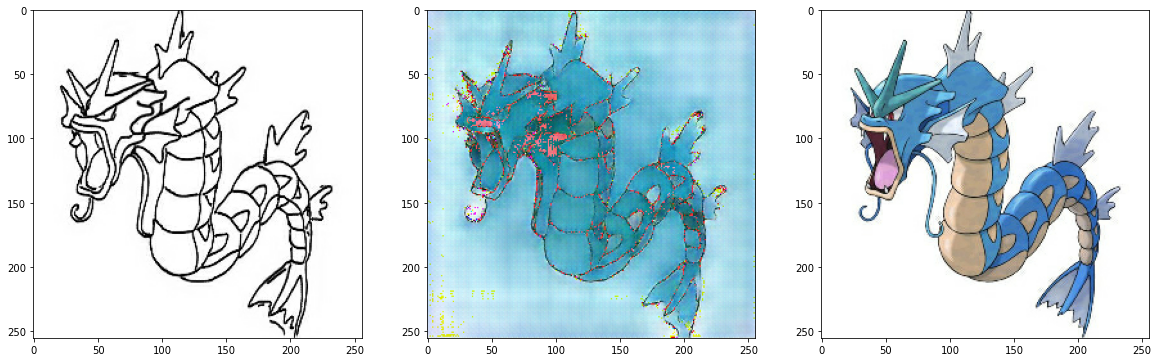

In [41]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [ ]:
EPOCHS = 1000

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0492                     
L1_loss:0.4714                     
Discriminator_loss:1.0962

EPOCH[1] - STEP[20]                     
Generator_loss:0.9453                     
L1_loss:0.3564                     
Discriminator_loss:1.2902

EPOCH[1] - STEP[30]                     
Generator_loss:0.6808                     
L1_loss:0.2730                     
Discriminator_loss:1.3206

EPOCH[1] - STEP[40]                     
Generator_loss:0.7387                     
L1_loss:0.2819                     
Discriminator_loss:1.2275

EPOCH[1] - STEP[50]                     
Generator_loss:1.4527                     
L1_loss:0.3003                     
Discriminator_loss:0.8854

EPOCH[1] - STEP[60]                     
Generator_loss:1.6250                     
L1_loss:0.3313                     
Discriminator_loss:0.8062

EPOCH[1] - STEP[70]                     
Generator_loss:2.0923                     
L1_loss:0.2588                    

EPOCH[3] - STEP[170]                     
Generator_loss:2.0316                     
L1_loss:0.2388                     
Discriminator_loss:0.5616

EPOCH[3] - STEP[180]                     
Generator_loss:1.6947                     
L1_loss:0.2104                     
Discriminator_loss:0.7976

EPOCH[3] - STEP[190]                     
Generator_loss:3.1901                     
L1_loss:0.2501                     
Discriminator_loss:0.3110

EPOCH[3] - STEP[200]                     
Generator_loss:3.6154                     
L1_loss:0.2524                     
Discriminator_loss:0.7177

EPOCH[4] - STEP[10]                     
Generator_loss:1.2496                     
L1_loss:0.3330                     
Discriminator_loss:0.4799

EPOCH[4] - STEP[20]                     
Generator_loss:0.9802                     
L1_loss:0.2441                     
Discriminator_loss:0.6449

EPOCH[4] - STEP[30]                     
Generator_loss:1.5949                     
L1_loss:0.3542                

EPOCH[6] - STEP[130]                     
Generator_loss:2.2773                     
L1_loss:0.2253                     
Discriminator_loss:0.3848

EPOCH[6] - STEP[140]                     
Generator_loss:2.7594                     
L1_loss:0.2287                     
Discriminator_loss:1.1087

EPOCH[6] - STEP[150]                     
Generator_loss:3.2507                     
L1_loss:0.2681                     
Discriminator_loss:0.1462

EPOCH[6] - STEP[160]                     
Generator_loss:1.4218                     
L1_loss:0.2359                     
Discriminator_loss:0.5031

EPOCH[6] - STEP[170]                     
Generator_loss:3.9646                     
L1_loss:0.2613                     
Discriminator_loss:0.1462

EPOCH[6] - STEP[180]                     
Generator_loss:1.5376                     
L1_loss:0.3473                     
Discriminator_loss:0.5170

EPOCH[6] - STEP[190]                     
Generator_loss:2.9025                     
L1_loss:0.2211             

EPOCH[9] - STEP[90]                     
Generator_loss:1.3823                     
L1_loss:0.3174                     
Discriminator_loss:0.3653

EPOCH[9] - STEP[100]                     
Generator_loss:2.5940                     
L1_loss:0.3011                     
Discriminator_loss:0.6935

EPOCH[9] - STEP[110]                     
Generator_loss:3.9470                     
L1_loss:0.2467                     
Discriminator_loss:0.4692

EPOCH[9] - STEP[120]                     
Generator_loss:1.4591                     
L1_loss:0.2315                     
Discriminator_loss:0.4765

EPOCH[9] - STEP[130]                     
Generator_loss:1.0251                     
L1_loss:0.2098                     
Discriminator_loss:0.7399

EPOCH[9] - STEP[140]                     
Generator_loss:0.7968                     
L1_loss:0.2614                     
Discriminator_loss:0.7452

EPOCH[9] - STEP[150]                     
Generator_loss:2.2776                     
L1_loss:0.2310              

EPOCH[12] - STEP[50]                     
Generator_loss:2.9015                     
L1_loss:0.2164                     
Discriminator_loss:0.6928

EPOCH[12] - STEP[60]                     
Generator_loss:0.7782                     
L1_loss:0.2716                     
Discriminator_loss:0.7629

EPOCH[12] - STEP[70]                     
Generator_loss:1.1151                     
L1_loss:0.2641                     
Discriminator_loss:0.4955

EPOCH[12] - STEP[80]                     
Generator_loss:0.4210                     
L1_loss:0.2057                     
Discriminator_loss:1.3640

EPOCH[12] - STEP[90]                     
Generator_loss:2.3608                     
L1_loss:0.2912                     
Discriminator_loss:0.1393

EPOCH[12] - STEP[100]                     
Generator_loss:3.0196                     
L1_loss:0.2309                     
Discriminator_loss:0.3938

EPOCH[12] - STEP[110]                     
Generator_loss:1.8260                     
L1_loss:0.2476           

EPOCH[15] - STEP[10]                     
Generator_loss:1.9460                     
L1_loss:0.2918                     
Discriminator_loss:0.1863

EPOCH[15] - STEP[20]                     
Generator_loss:1.3553                     
L1_loss:0.2277                     
Discriminator_loss:0.7957

EPOCH[15] - STEP[30]                     
Generator_loss:1.7369                     
L1_loss:0.2573                     
Discriminator_loss:1.1788

EPOCH[15] - STEP[40]                     
Generator_loss:2.9676                     
L1_loss:0.2112                     
Discriminator_loss:1.7331

EPOCH[15] - STEP[50]                     
Generator_loss:3.9265                     
L1_loss:0.2485                     
Discriminator_loss:2.0084

EPOCH[15] - STEP[60]                     
Generator_loss:2.4190                     
L1_loss:0.2453                     
Discriminator_loss:0.2389

EPOCH[15] - STEP[70]                     
Generator_loss:1.3422                     
L1_loss:0.1969             

EPOCH[17] - STEP[170]                     
Generator_loss:0.2426                     
L1_loss:0.2338                     
Discriminator_loss:1.7412

EPOCH[17] - STEP[180]                     
Generator_loss:1.2983                     
L1_loss:0.2577                     
Discriminator_loss:0.3834

EPOCH[17] - STEP[190]                     
Generator_loss:3.0450                     
L1_loss:0.2788                     
Discriminator_loss:0.1102

EPOCH[17] - STEP[200]                     
Generator_loss:3.6158                     
L1_loss:0.2911                     
Discriminator_loss:0.7456

EPOCH[18] - STEP[10]                     
Generator_loss:1.1422                     
L1_loss:0.2528                     
Discriminator_loss:0.8392

EPOCH[18] - STEP[20]                     
Generator_loss:2.5385                     
L1_loss:0.2180                     
Discriminator_loss:0.4246

EPOCH[18] - STEP[30]                     
Generator_loss:0.7567                     
L1_loss:0.2437         

EPOCH[20] - STEP[130]                     
Generator_loss:0.2333                     
L1_loss:0.3163                     
Discriminator_loss:1.7313

EPOCH[20] - STEP[140]                     
Generator_loss:2.2698                     
L1_loss:0.2049                     
Discriminator_loss:0.5979

EPOCH[20] - STEP[150]                     
Generator_loss:0.1047                     
L1_loss:0.2824                     
Discriminator_loss:2.7055

EPOCH[20] - STEP[160]                     
Generator_loss:3.7024                     
L1_loss:0.2336                     
Discriminator_loss:0.1726

EPOCH[20] - STEP[170]                     
Generator_loss:0.8604                     
L1_loss:0.2161                     
Discriminator_loss:0.6208

EPOCH[20] - STEP[180]                     
Generator_loss:1.8792                     
L1_loss:0.2854                     
Discriminator_loss:0.2020

EPOCH[20] - STEP[190]                     
Generator_loss:1.5839                     
L1_loss:0.2527      

EPOCH[23] - STEP[90]                     
Generator_loss:2.2684                     
L1_loss:0.2077                     
Discriminator_loss:1.2115

EPOCH[23] - STEP[100]                     
Generator_loss:2.7132                     
L1_loss:0.2273                     
Discriminator_loss:0.2193

EPOCH[23] - STEP[110]                     
Generator_loss:3.1752                     
L1_loss:0.2224                     
Discriminator_loss:0.7439

EPOCH[23] - STEP[120]                     
Generator_loss:3.4121                     
L1_loss:0.2994                     
Discriminator_loss:0.0545

EPOCH[23] - STEP[130]                     
Generator_loss:2.1697                     
L1_loss:0.2402                     
Discriminator_loss:0.2676

EPOCH[23] - STEP[140]                     
Generator_loss:0.4325                     
L1_loss:0.2203                     
Discriminator_loss:1.2932

EPOCH[23] - STEP[150]                     
Generator_loss:0.5991                     
L1_loss:0.2019       

EPOCH[26] - STEP[50]                     
Generator_loss:2.8187                     
L1_loss:0.2841                     
Discriminator_loss:0.1609

EPOCH[26] - STEP[60]                     
Generator_loss:3.1698                     
L1_loss:0.2379                     
Discriminator_loss:0.2473

EPOCH[26] - STEP[70]                     
Generator_loss:2.8337                     
L1_loss:0.2301                     
Discriminator_loss:1.0081

EPOCH[26] - STEP[80]                     
Generator_loss:1.1526                     
L1_loss:0.2509                     
Discriminator_loss:0.5098

EPOCH[26] - STEP[90]                     
Generator_loss:2.3543                     
L1_loss:0.2165                     
Discriminator_loss:0.4154

EPOCH[26] - STEP[100]                     
Generator_loss:1.6123                     
L1_loss:0.2219                     
Discriminator_loss:0.3220

EPOCH[26] - STEP[110]                     
Generator_loss:2.2067                     
L1_loss:0.2584           

EPOCH[29] - STEP[10]                     
Generator_loss:2.1522                     
L1_loss:0.2615                     
Discriminator_loss:0.3396

EPOCH[29] - STEP[20]                     
Generator_loss:1.4368                     
L1_loss:0.2437                     
Discriminator_loss:1.0443

EPOCH[29] - STEP[30]                     
Generator_loss:3.1813                     
L1_loss:0.2257                     
Discriminator_loss:0.9494

EPOCH[29] - STEP[40]                     
Generator_loss:2.6884                     
L1_loss:0.2408                     
Discriminator_loss:0.3229

EPOCH[29] - STEP[50]                     
Generator_loss:4.4915                     
L1_loss:0.2557                     
Discriminator_loss:1.2758

EPOCH[29] - STEP[60]                     
Generator_loss:2.6618                     
L1_loss:0.3189                     
Discriminator_loss:0.5194

EPOCH[29] - STEP[70]                     
Generator_loss:0.9150                     
L1_loss:0.1913             

EPOCH[31] - STEP[170]                     
Generator_loss:2.6157                     
L1_loss:0.2119                     
Discriminator_loss:1.2777

EPOCH[31] - STEP[180]                     
Generator_loss:1.9932                     
L1_loss:0.2808                     
Discriminator_loss:0.2620

EPOCH[31] - STEP[190]                     
Generator_loss:2.5405                     
L1_loss:0.2226                     
Discriminator_loss:0.6255

EPOCH[31] - STEP[200]                     
Generator_loss:1.9457                     
L1_loss:0.2459                     
Discriminator_loss:0.9743

EPOCH[32] - STEP[10]                     
Generator_loss:2.6909                     
L1_loss:0.1941                     
Discriminator_loss:1.0986

EPOCH[32] - STEP[20]                     
Generator_loss:2.0241                     
L1_loss:0.2240                     
Discriminator_loss:0.2589

EPOCH[32] - STEP[30]                     
Generator_loss:2.8481                     
L1_loss:0.2289         

In [ ]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))